# Can you predict negative news by insider trading.

When a company has a significant event that effects company operations, it is required to file a Current Event Report (Form 8-K). I am curious if it is possible to predict negative or positive news based on insider trading disclosures (Form 4), which are required to be filed within 2 periods.

My hypothesis was that insiders who know that there is good news coming, and are planning to sell their shares, will wait to sell their shares until after the news breaks. Vice versa, if bad news is coming, insiders would like to sell shares immediately. However, this is likely illegal - and so the effect would be smaller.

## Data Construction
Data was constructed from every 8-K & Form 4 in 2024. See `construct_4_data.py`, `construct_8k_data.py`, and `construct_data.py`. Sells are determined if a Form 4's first transaction is a 'Disposal' and Buys if first transaction is 'Acquisition'. Sentiment Analysis is from Loughran McDonald dictionaries.

## Disclaimer
This exploration is not meant to be scientifically rigorous. If there is an effect, the rigor can be applied later.

## Plotting

Let's do some basic plots.

C:\Users\jgfri\AppData\Local\Temp\ipykernel_10640\863569258.py:66: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


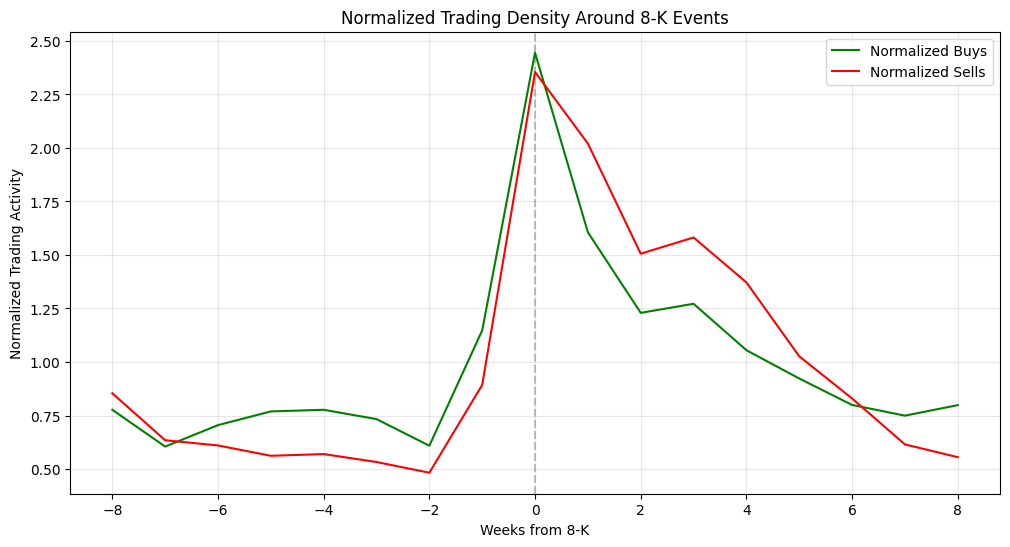

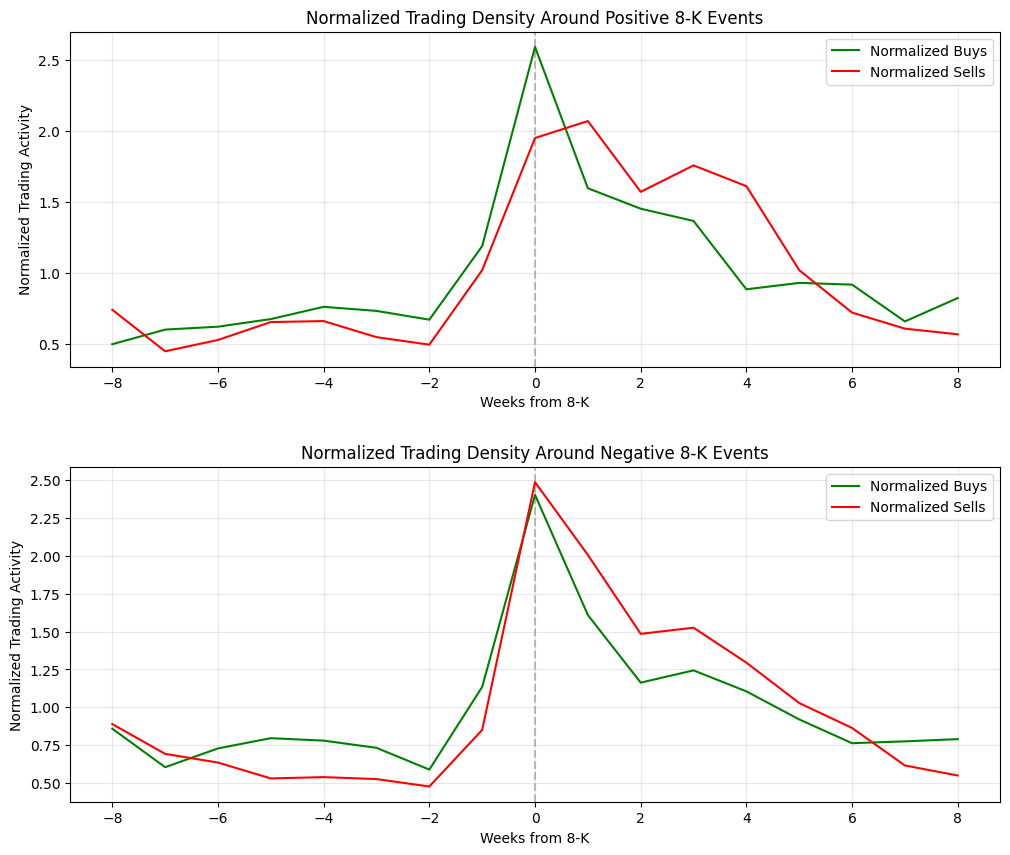

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def plot_event_density(results_df):
    # Aggregate by period
    agg = results_df.groupby('period').agg({
        'buys': 'mean',
        'sells': 'mean'
    }).reset_index()
    
    # Normalize buys and sells separately 
    agg['norm_buys'] = agg['buys'] / agg['buys'].mean()
    agg['norm_sells'] = agg['sells'] / agg['sells'].mean()
    
    # Plot
    plt.figure(figsize=(12, 6))
    
    # Plot event line at period 0 with neutral gray color
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
    
    # Plot normalized trading density
    plt.plot(agg['period'], agg['norm_buys'], label='Normalized Buys', color='green')
    plt.plot(agg['period'], agg['norm_sells'], label='Normalized Sells', color='red')
    
    plt.xlabel('Weeks from 8-K')
    plt.ylabel('Normalized Trading Activity')
    plt.title('Normalized Trading Density Around 8-K Events')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt

def plot_by_sentiment(results_df):
    # Create figure with subfigures using GridSpec for better control
    fig = plt.figure(figsize=(12, 10))
    gs = fig.add_gridspec(2, 1, hspace=0.3)
    
    results_df['pos_sentiment'] = results_df['sentiment'] > 0
    
    for idx, (sentiment, label) in enumerate([(True, 'Positive'), (False, 'Negative')]):
        ax = fig.add_subplot(gs[idx])
        data = results_df[results_df['pos_sentiment'] == sentiment]
        
        agg = data.groupby('period').agg({
            'buys': 'mean',
            'sells': 'mean'
        }).reset_index()
        
        # Normalize buys and sells separately
        agg['norm_buys'] = agg['buys'] / agg['buys'].mean()
        agg['norm_sells'] = agg['sells'] / agg['sells'].mean()
        
        # Plot event line with neutral gray color
        ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        ax.plot(agg['period'], agg['norm_buys'], label='Normalized Buys', color='green')
        ax.plot(agg['period'], agg['norm_sells'], label='Normalized Sells', color='red')
        
        ax.set_xlabel('Weeks from 8-K')
        ax.set_ylabel('Normalized Trading Activity')
        ax.set_title(f'Normalized Trading Density Around {label} 8-K Events')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return plt

# Usage remains the same:
results = pd.read_csv('data/dataset.csv')
fig1 = plot_event_density(results)
fig1.savefig('plots/trading_8k.png')
fig2 = plot_by_sentiment(results)
fig2.savefig('plots/trading_8k_buy_sell.png')
plt.show()

Let's put the plots side by side to better see the effects.

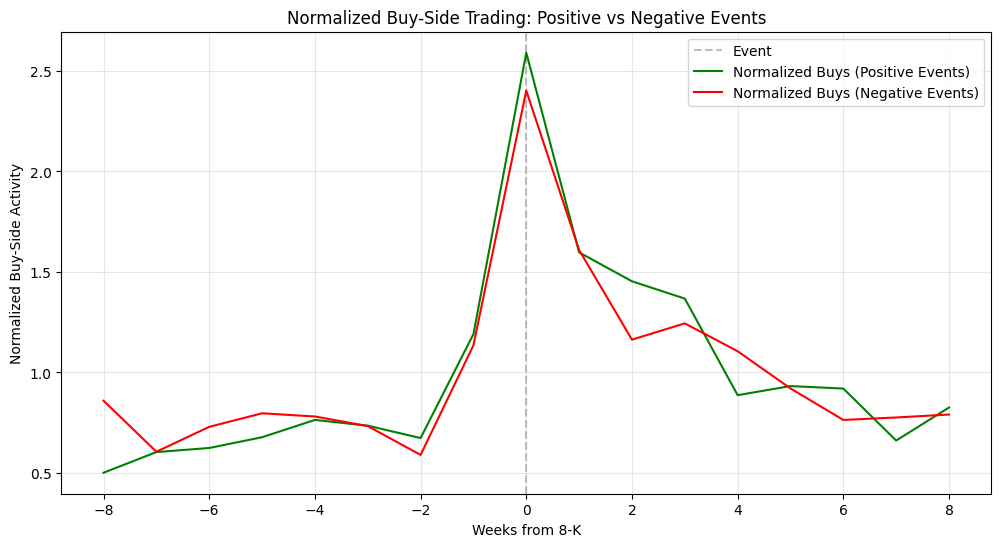

In [2]:
def plot_buy_side_comparison(results_df):
    # Create positive/negative sentiment indicator
    results_df['pos_sentiment'] = results_df['sentiment'] > 0
    
    # Create figure
    plt.figure(figsize=(12, 6))
    
    # Split and aggregate data for positive and negative events
    pos_data = results_df[results_df['pos_sentiment']].groupby('period')['buys'].mean().reset_index()
    neg_data = results_df[~results_df['pos_sentiment']].groupby('period')['buys'].mean().reset_index()
    
    # Normalize each series by its own mean
    pos_data['norm_buys'] = pos_data['buys'] / pos_data['buys'].mean()
    neg_data['norm_buys'] = neg_data['buys'] / neg_data['buys'].mean()
    
    # Plot event line
    plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Event')
    
    # Plot normalized buy-side activity
    plt.plot(pos_data['period'], pos_data['norm_buys'], 
             label='Normalized Buys (Positive Events)', 
             color='green', 
             linestyle='-')
    
    plt.plot(neg_data['period'], neg_data['norm_buys'], 
             label='Normalized Buys (Negative Events)', 
             color='red', 
             linestyle='-')
    
    plt.xlabel('Weeks from 8-K')
    plt.ylabel('Normalized Buy-Side Activity')
    plt.title('Normalized Buy-Side Trading: Positive vs Negative Events')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    return plt

# Usage:
results = pd.read_csv('data/dataset.csv')
fig = plot_buy_side_comparison(results)
fig.savefig('plots/trading_8k_buy_side.png')
plt.show()

Not much difference between the buys behavior for positive and negative events.

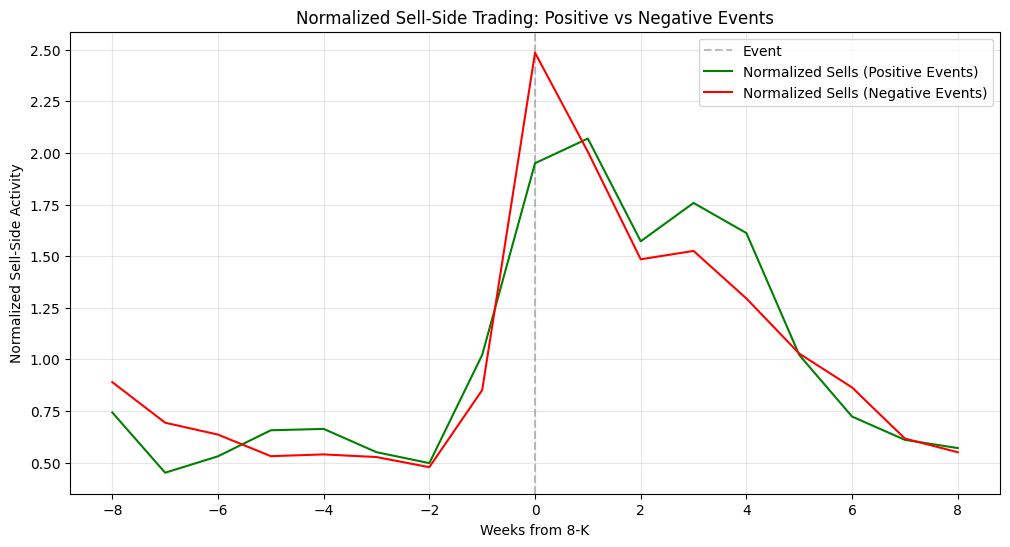

In [3]:
def plot_sell_side_comparison(results_df):
   # Create positive/negative sentiment indicator 
   results_df['pos_sentiment'] = results_df['sentiment'] > 0
   
   # Create figure
   plt.figure(figsize=(12, 6))
   
   # Split and aggregate data for positive and negative events
   pos_data = results_df[results_df['pos_sentiment']].groupby('period')['sells'].mean().reset_index()
   neg_data = results_df[~results_df['pos_sentiment']].groupby('period')['sells'].mean().reset_index()
   
   # Normalize each series by its own mean
   pos_data['norm_sells'] = pos_data['sells'] / pos_data['sells'].mean()
   neg_data['norm_sells'] = neg_data['sells'] / neg_data['sells'].mean()
   
   # Plot event line
   plt.axvline(x=0, color='gray', linestyle='--', alpha=0.5, label='Event')
   
   # Plot normalized sell-side activity
   plt.plot(pos_data['period'], pos_data['norm_sells'], 
            label='Normalized Sells (Positive Events)', 
            color='green', 
            linestyle='-')
   
   plt.plot(neg_data['period'], neg_data['norm_sells'], 
            label='Normalized Sells (Negative Events)', 
            color='red', 
            linestyle='-')
   
   plt.xlabel('Weeks from 8-K')
   plt.ylabel('Normalized Sell-Side Activity')
   plt.title('Normalized Sell-Side Trading: Positive vs Negative Events')
   plt.legend()
   plt.grid(True, alpha=0.3)
   
   return plt

# Usage:
results = pd.read_csv('data/dataset.csv')
fig = plot_sell_side_comparison(results)
fig.savefig('plots/trading_8k_sell_side.png')
plt.show()

Wow. That looks like a strong effect.

## Analysis

### Pre-period

It looks like there is very little insider disclosures before a current report. There are probably 2 reasons for this:
1. In the data construction I excluded overlapping events
2. Insider trading is illegal, and buying/selling a large amount of stock before an important event might land you in jail.

### Period 0
Most activity is done on this day. Probably explained due to legal reasons.

### Post-period
* Bad Event - dispose of stock ASAP
* Good Event - wait, peak sells are at week 1, but continue to be fairly high until week 4.

I find the two peaks for Good + Sells at Week 1 and Week 3 to be interesting. Not sure why that would be - maybe media cycle?


### Predicting Good/Bad News

Doesn't look like we can use this data to predict news. There's very little activity before an 8-K is released, and there also are not that many form 4 filings per company per year, so not a lot of data.

## Conclusion

When there is good news, insiders wait to sell their stocks. The duration is interesting - it could reflect waiting for the goods news to permeate the market.

Another possibility is that an 8-K reveals good news, but not how good the news is. This might trickle out over time, and the insider may choose to wait until the market has the full story before selling.

## Addendum

###  I'm curious, whether you noticed any difference by industries (e.g., tech vs. manufacturing)?
From Oktay Bogazkaya

C:\Users\jgfri\AppData\Local\Temp\ipykernel_10640\2444558236.py:15: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(2, 1, figsize=(12, 12))


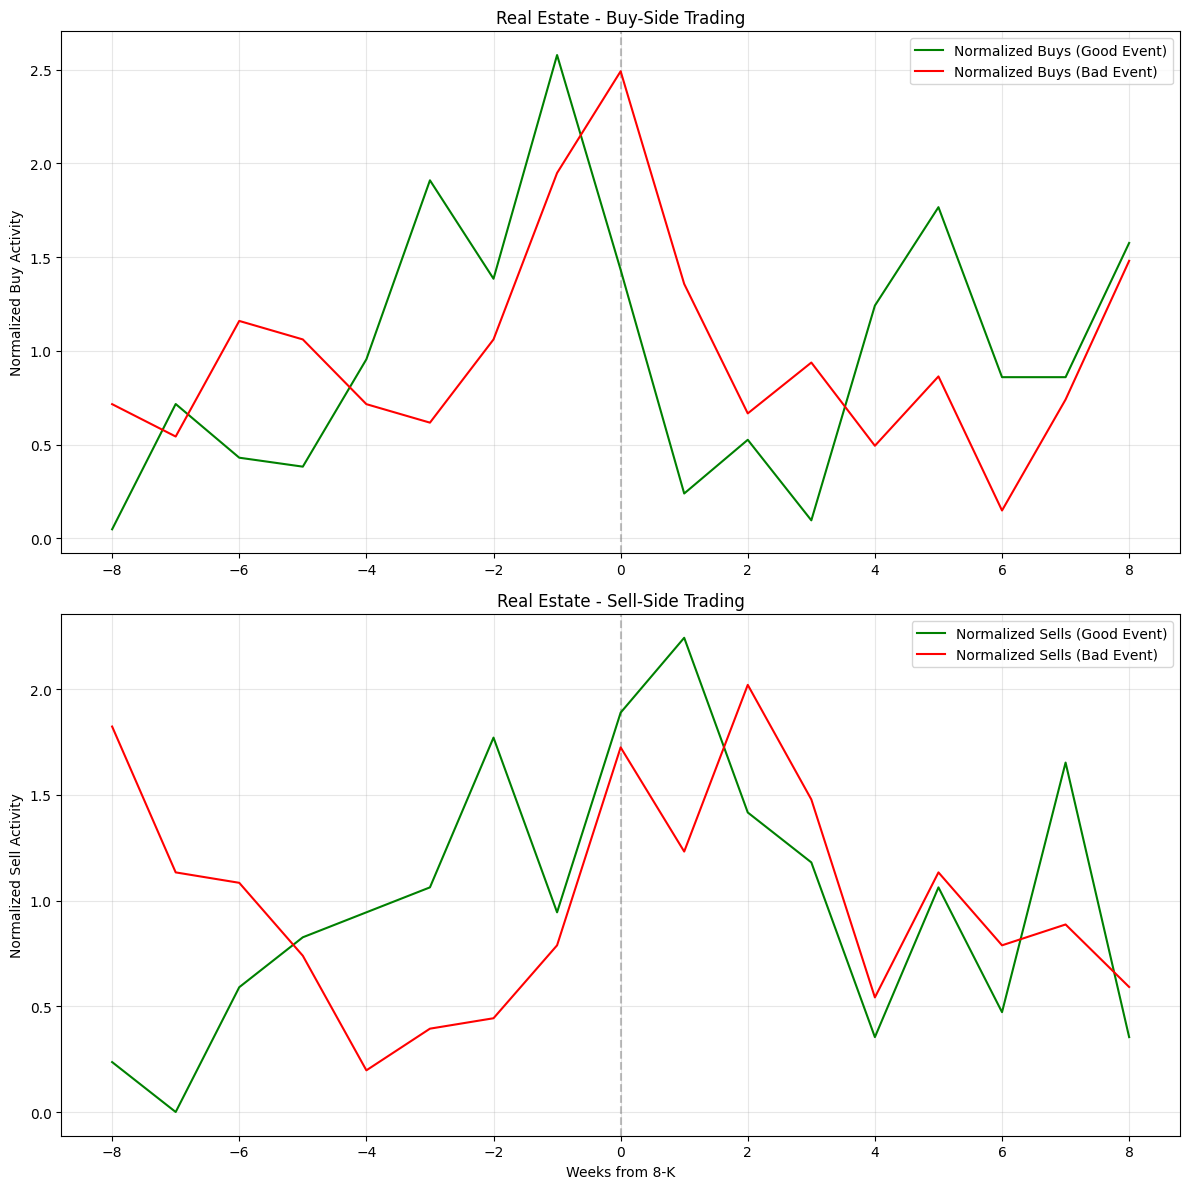

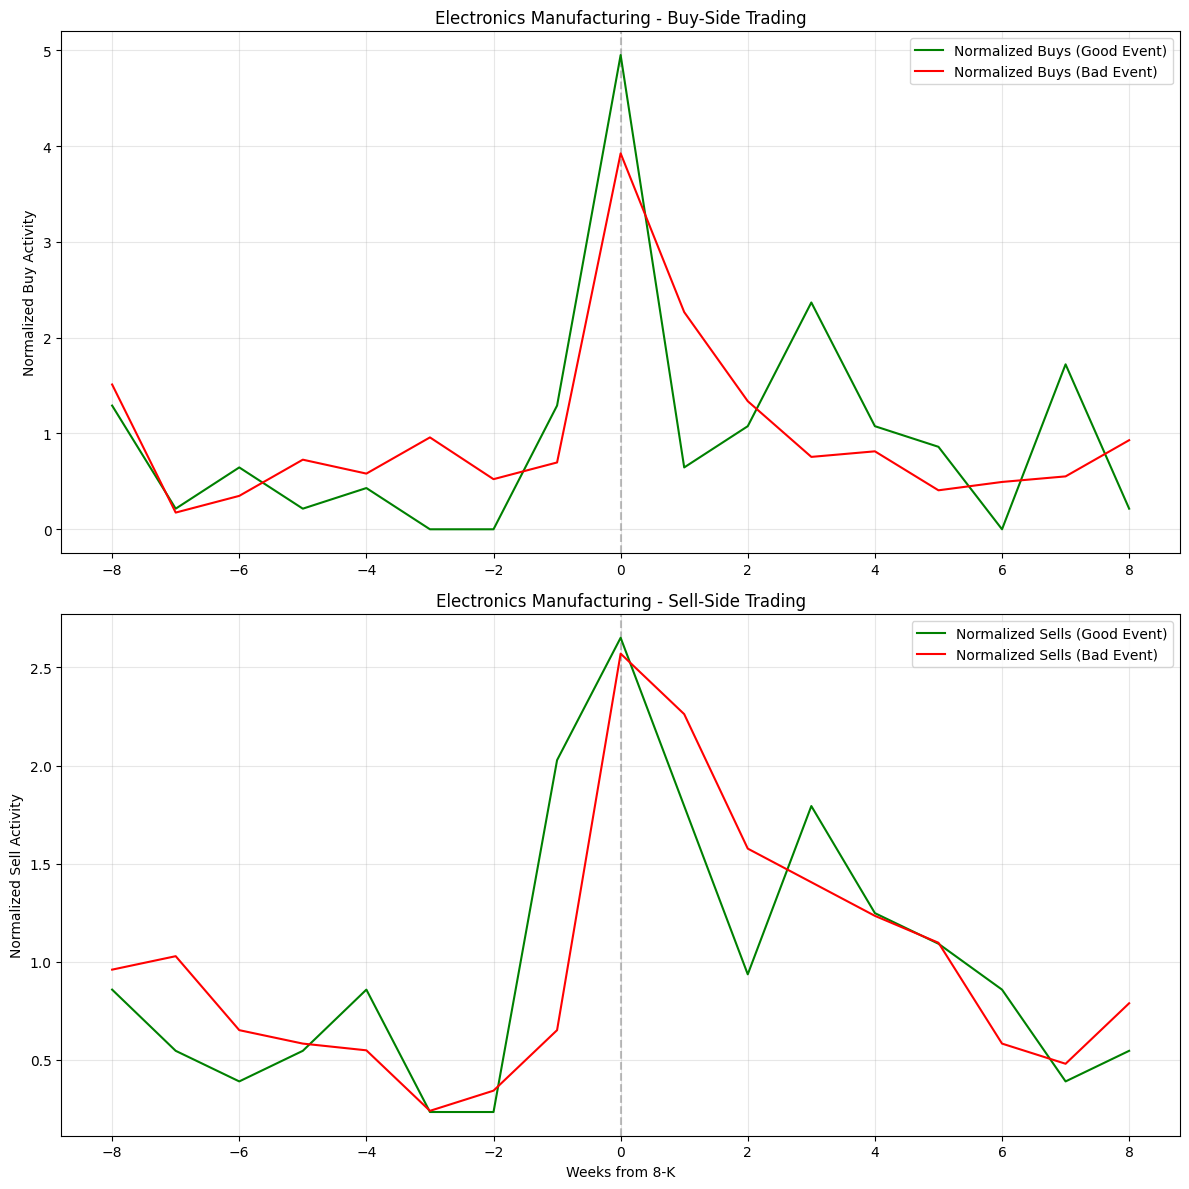

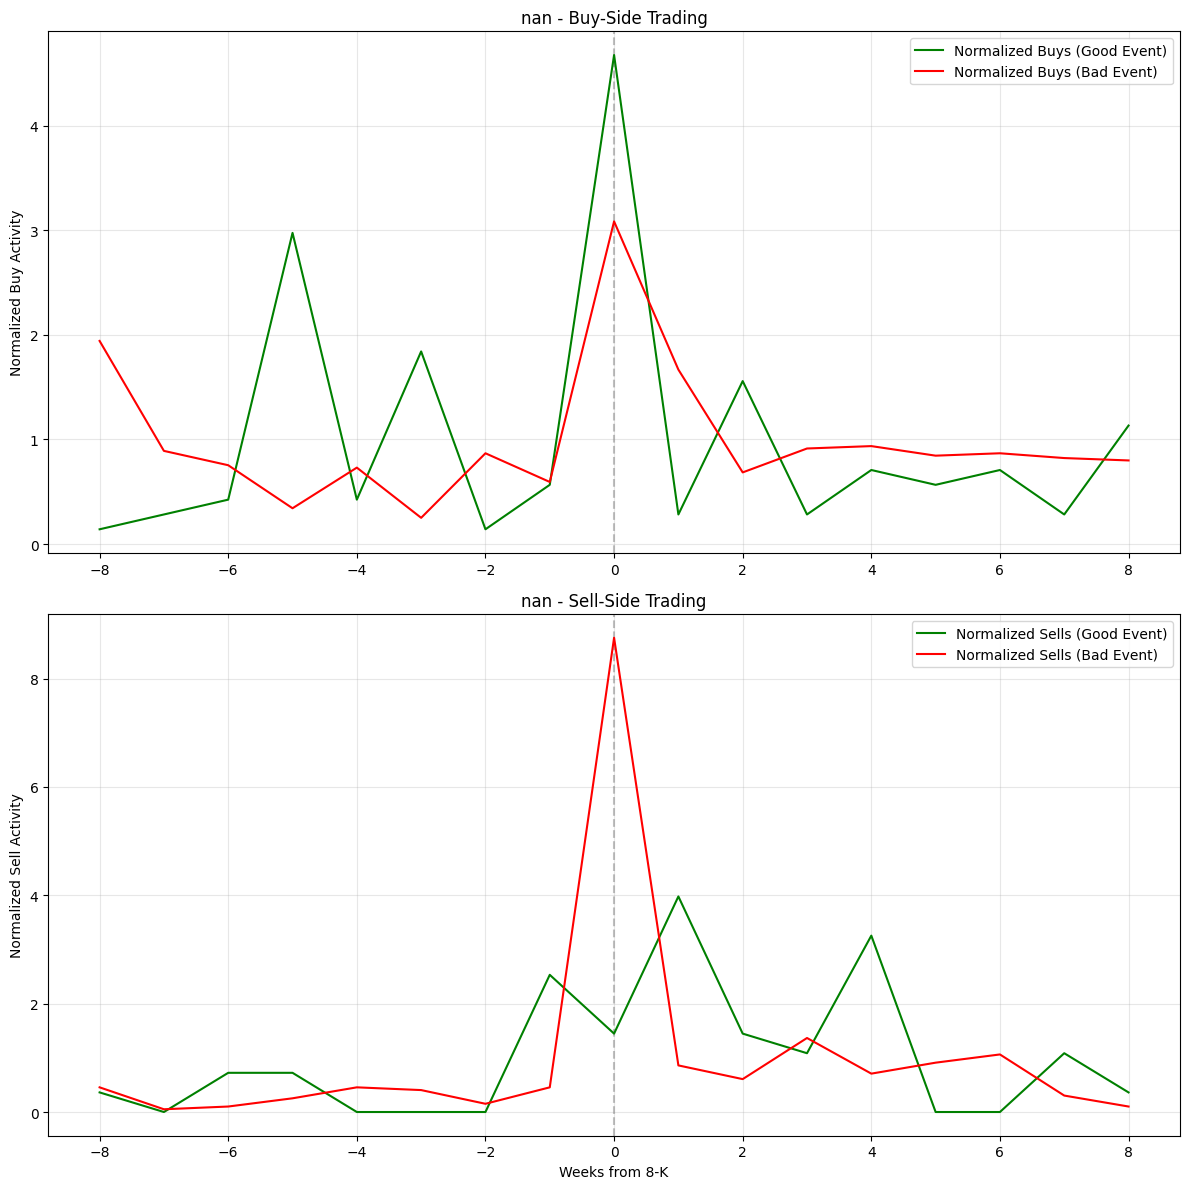

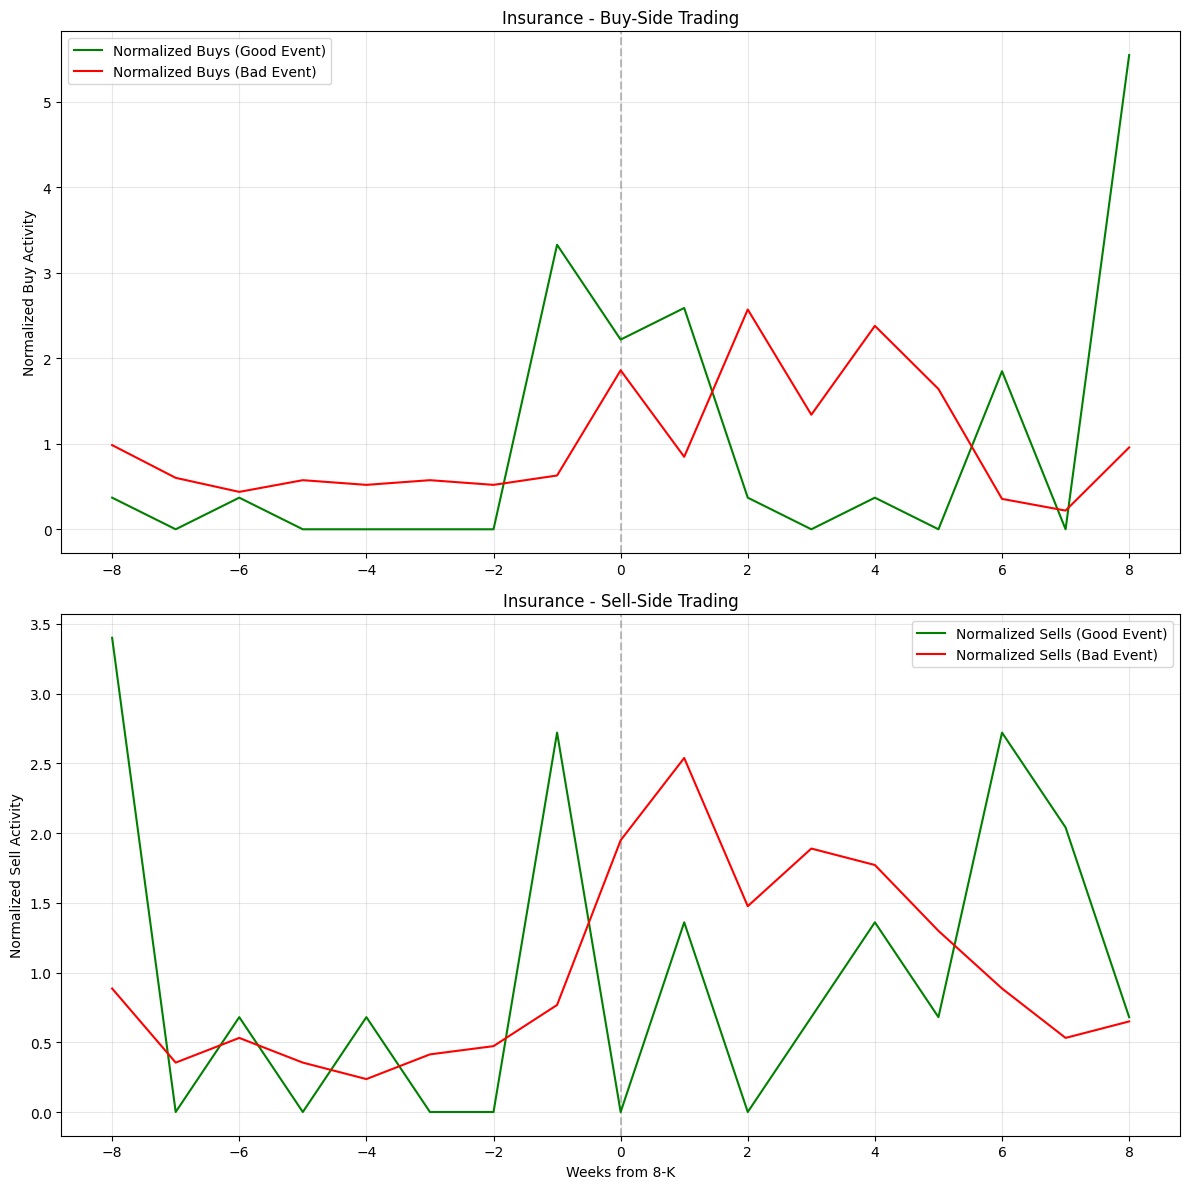

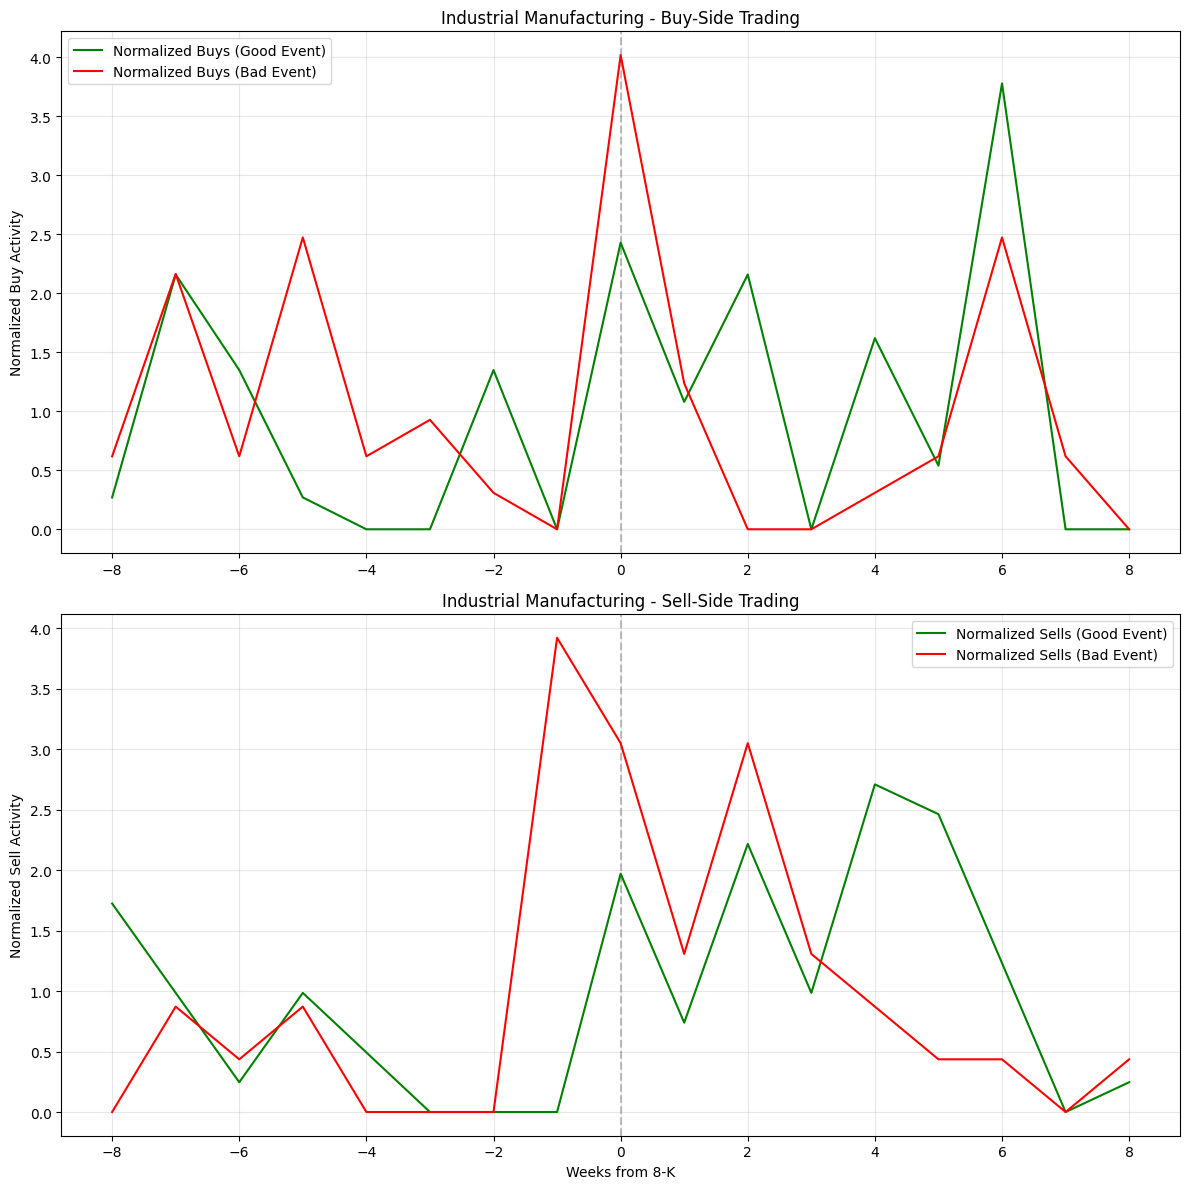

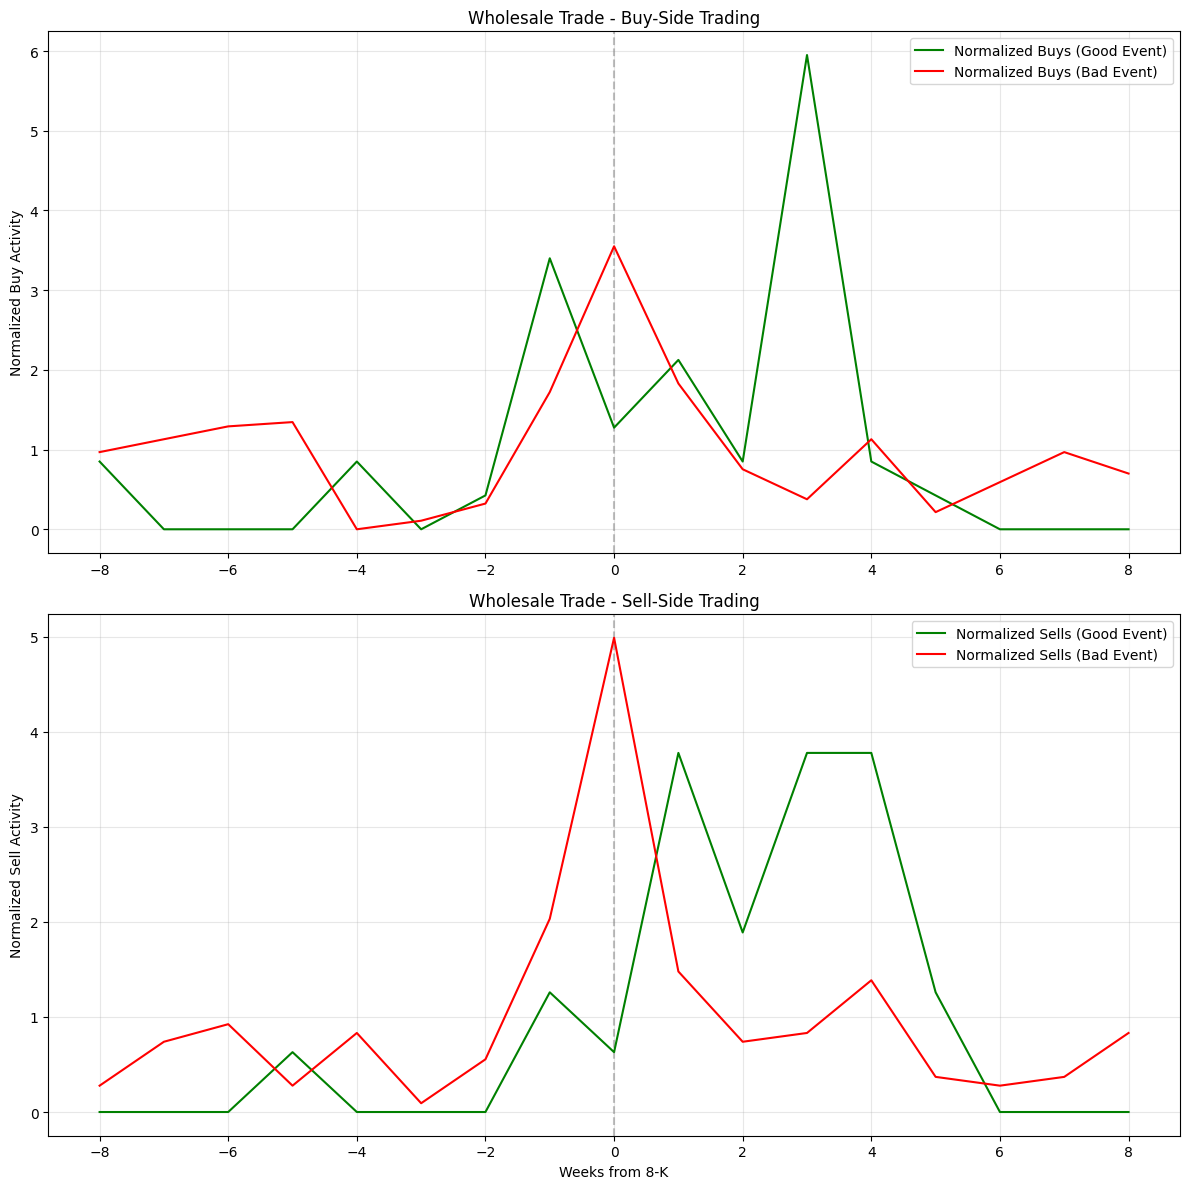

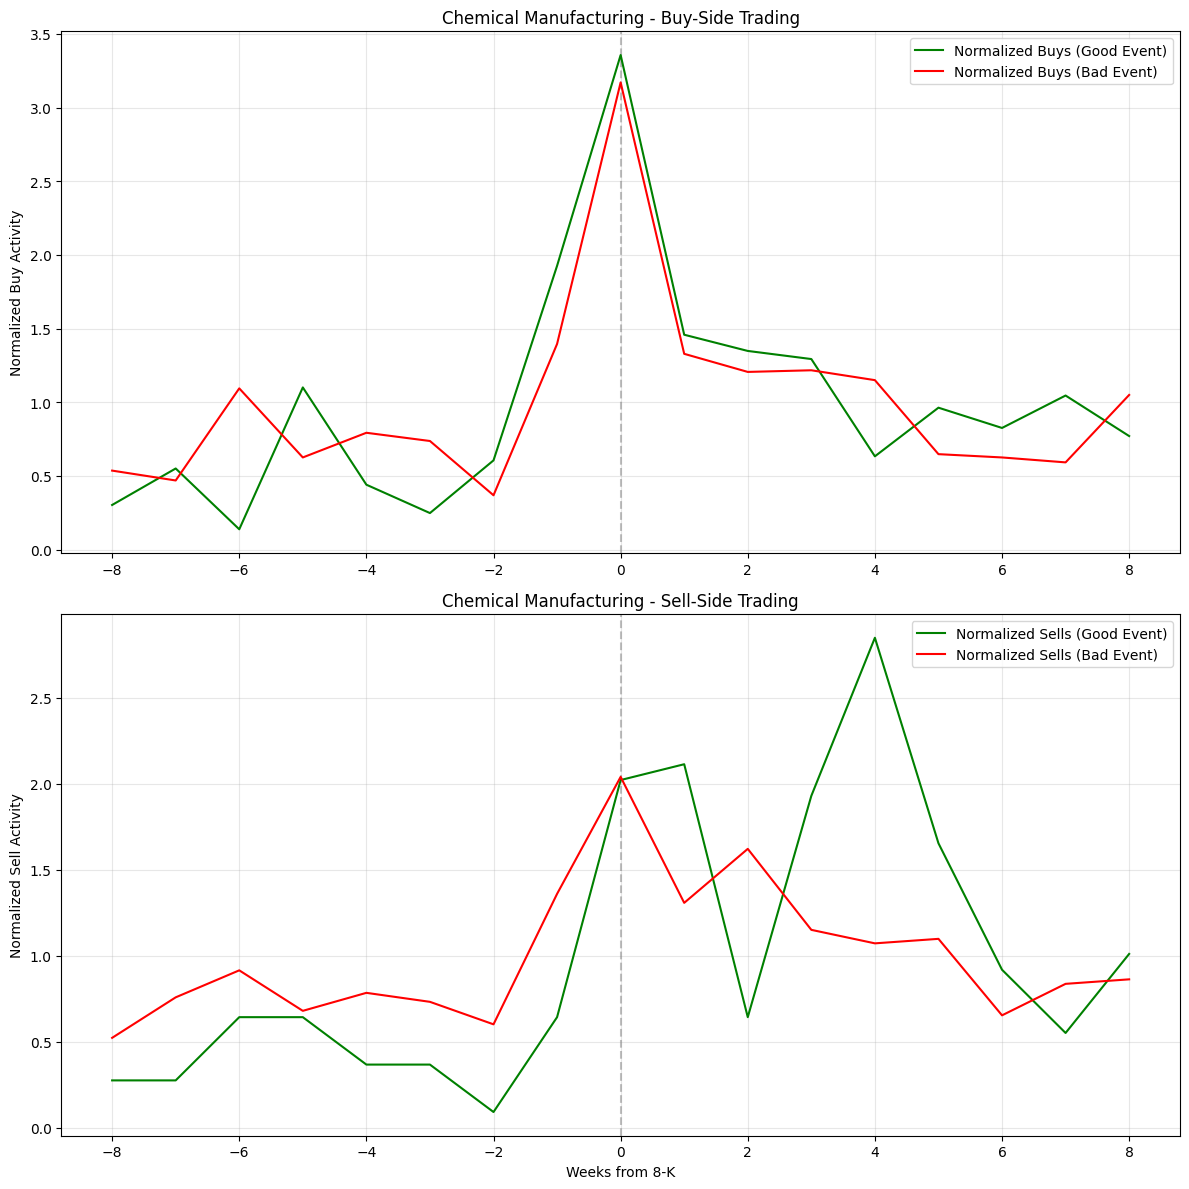

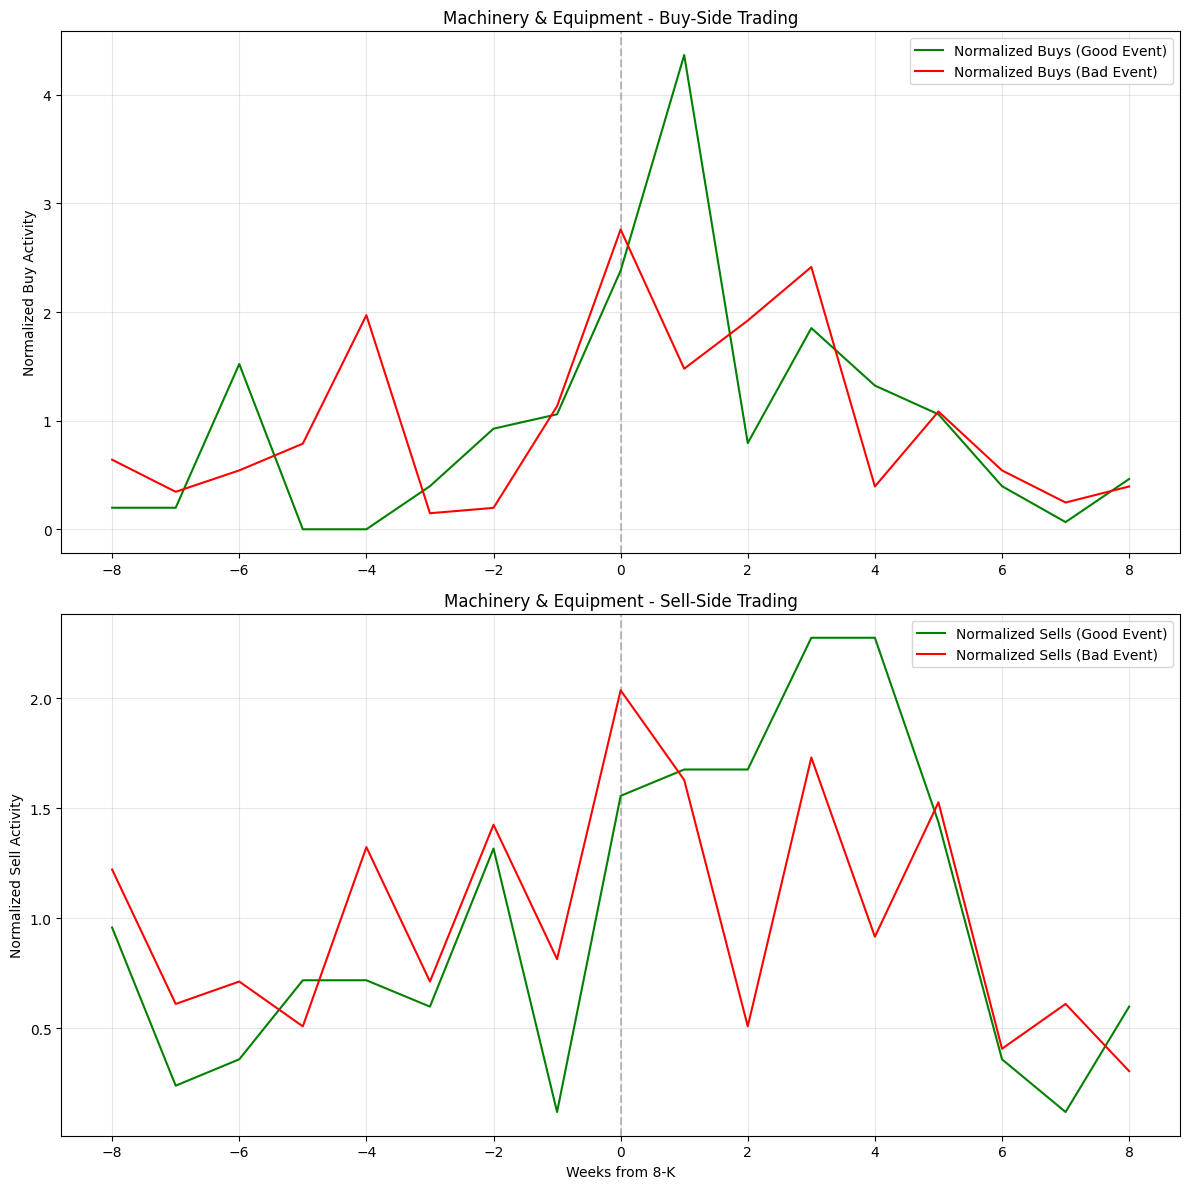

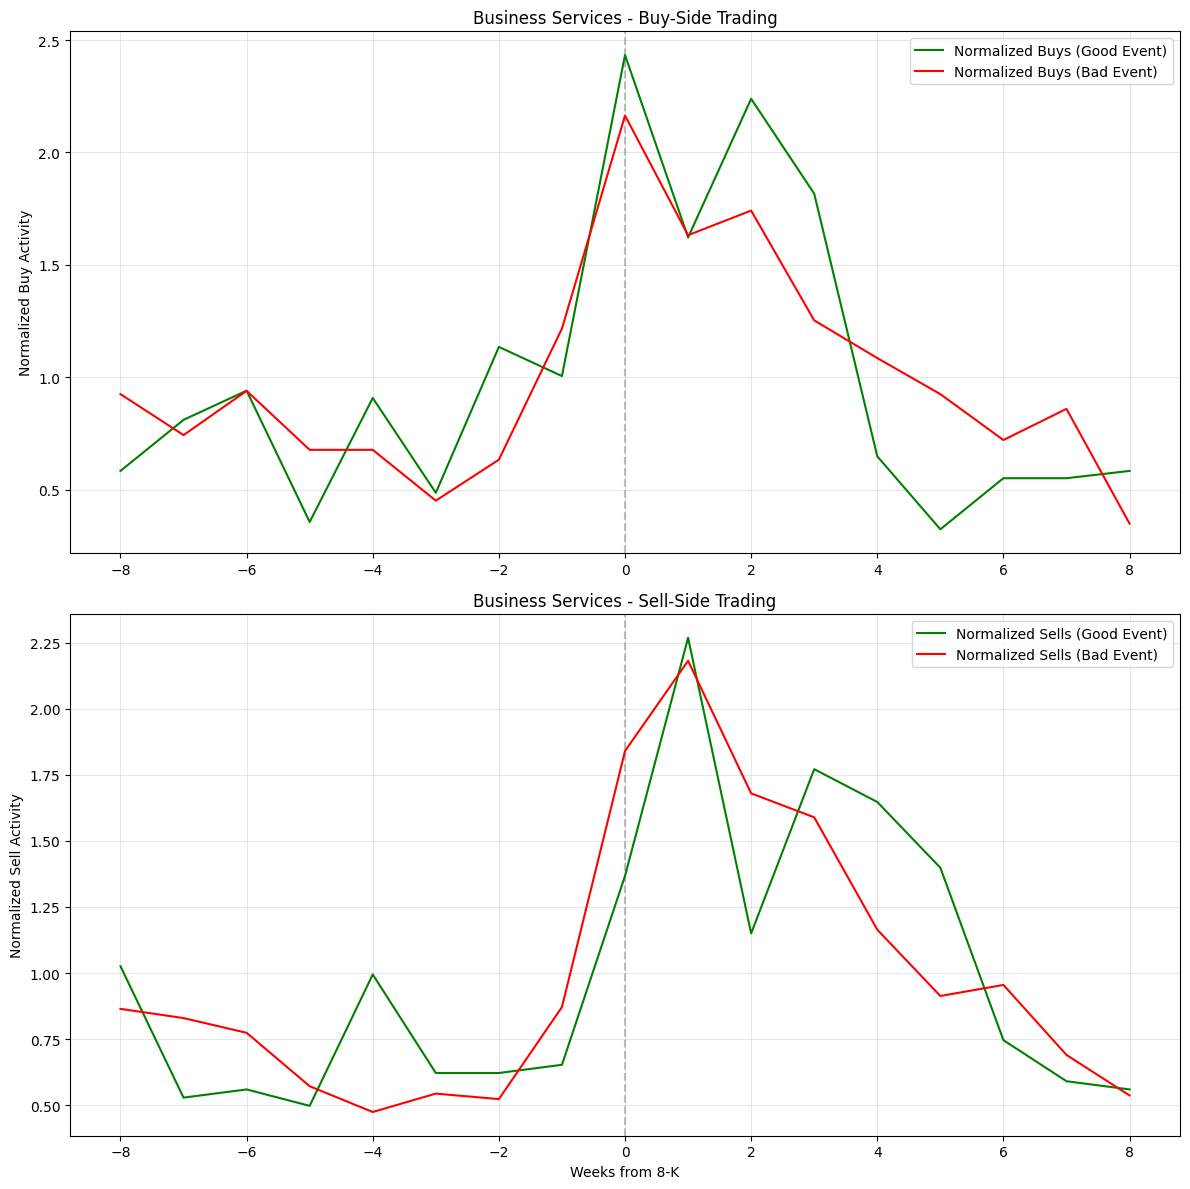

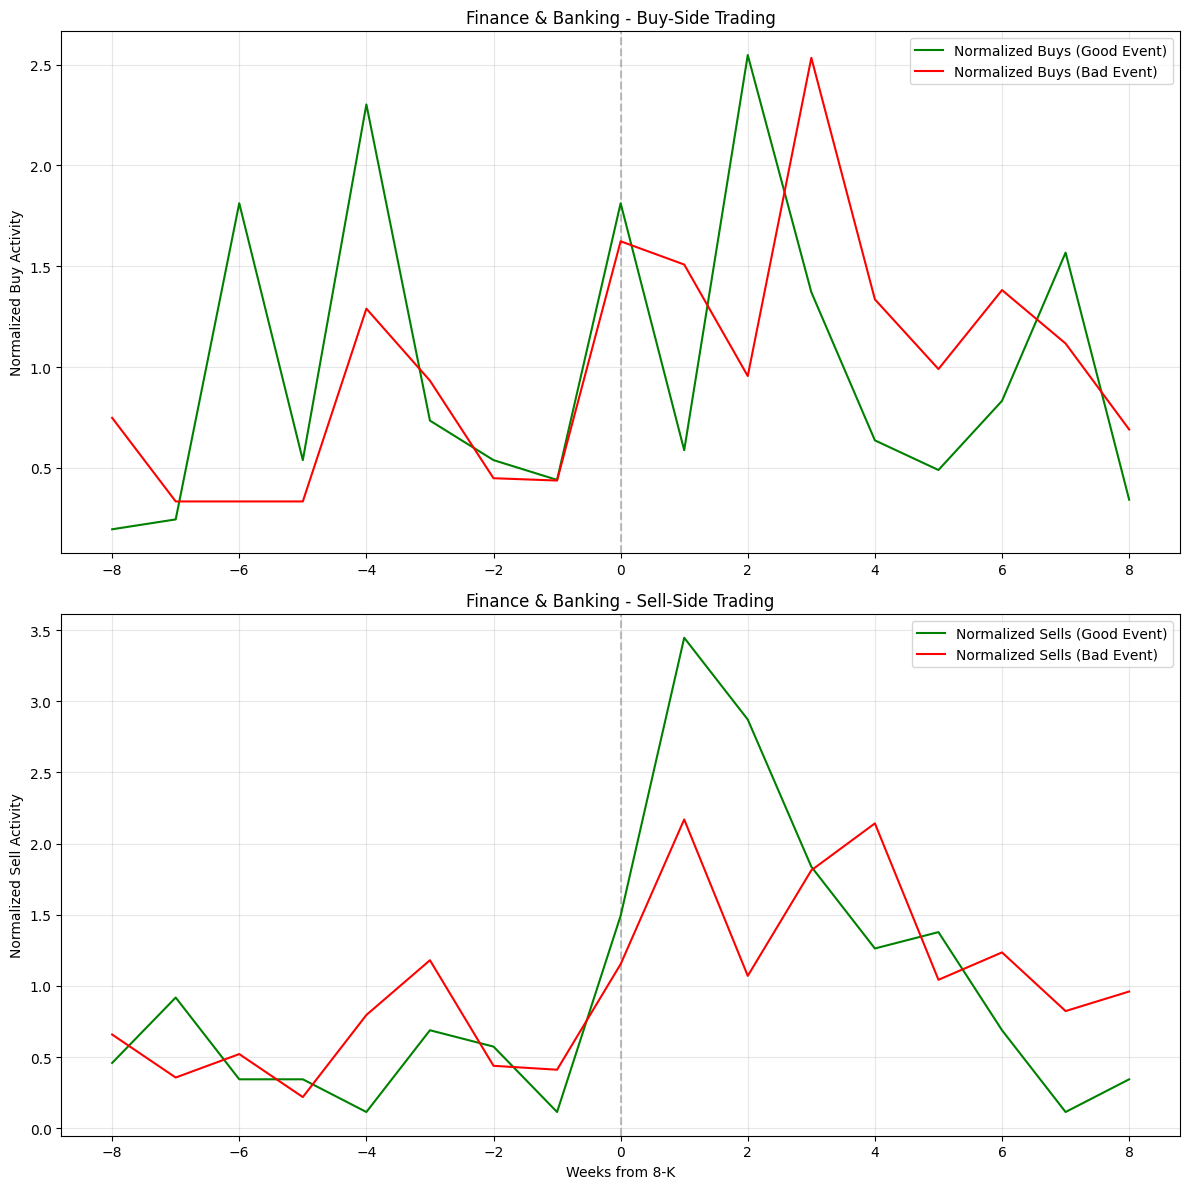

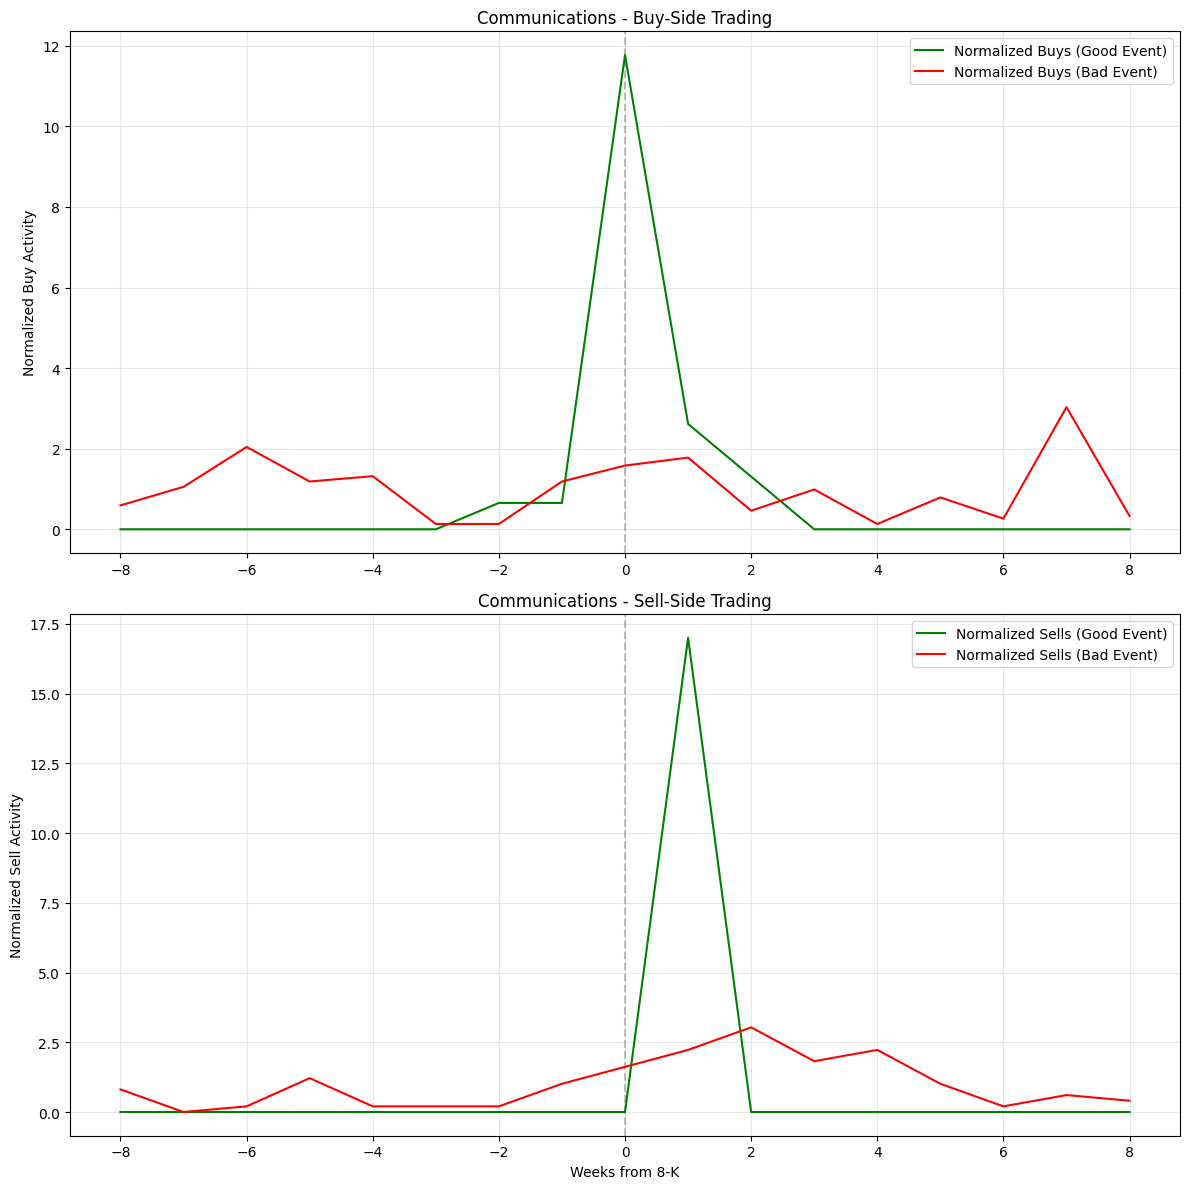

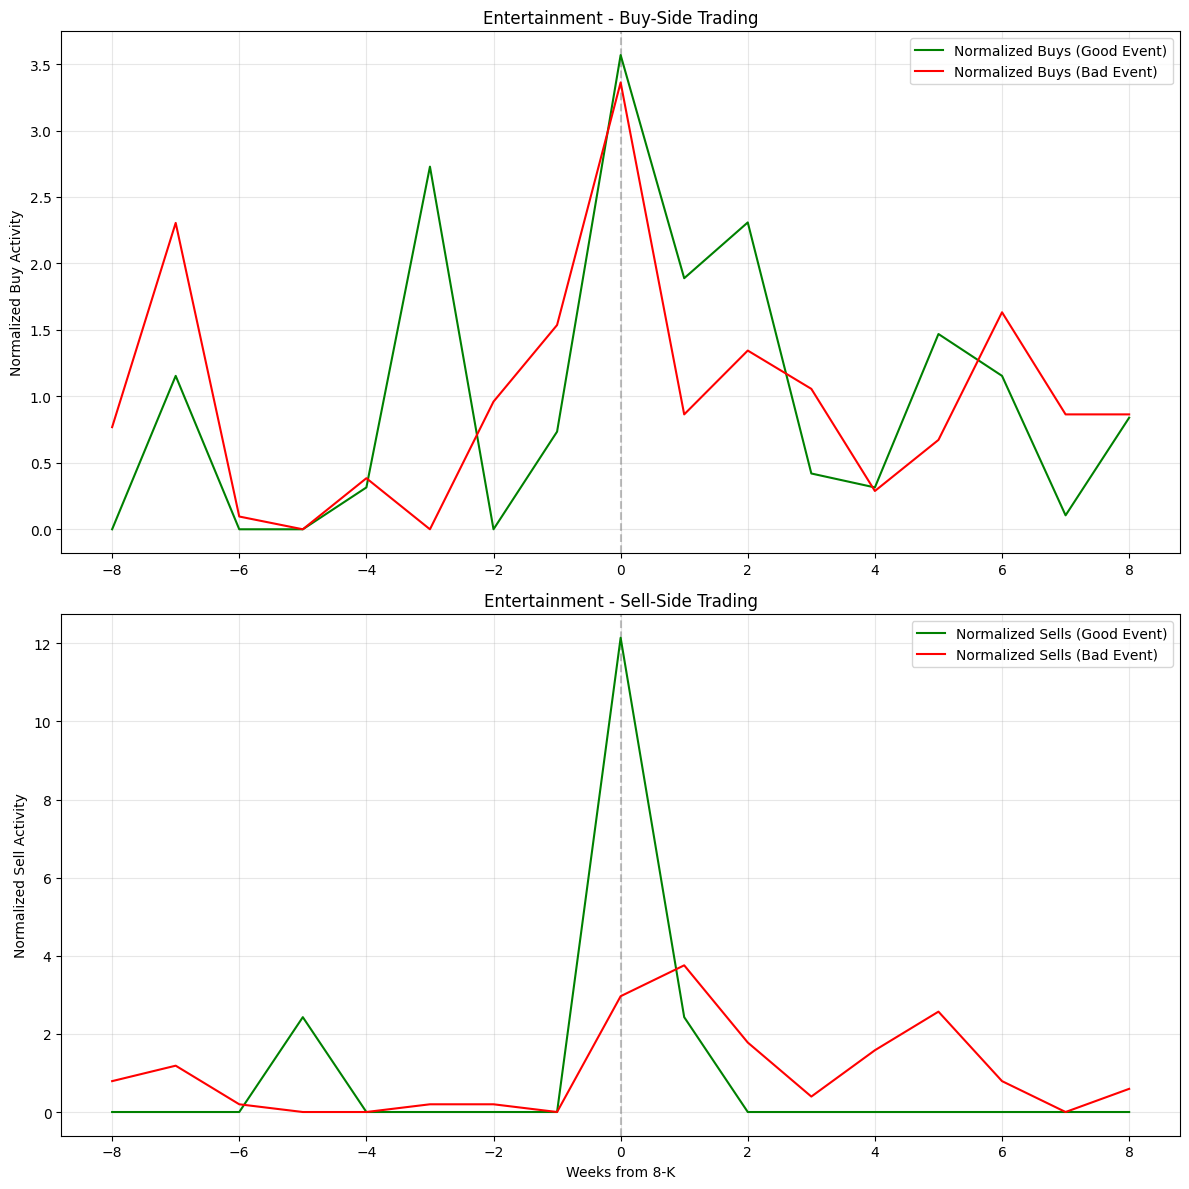

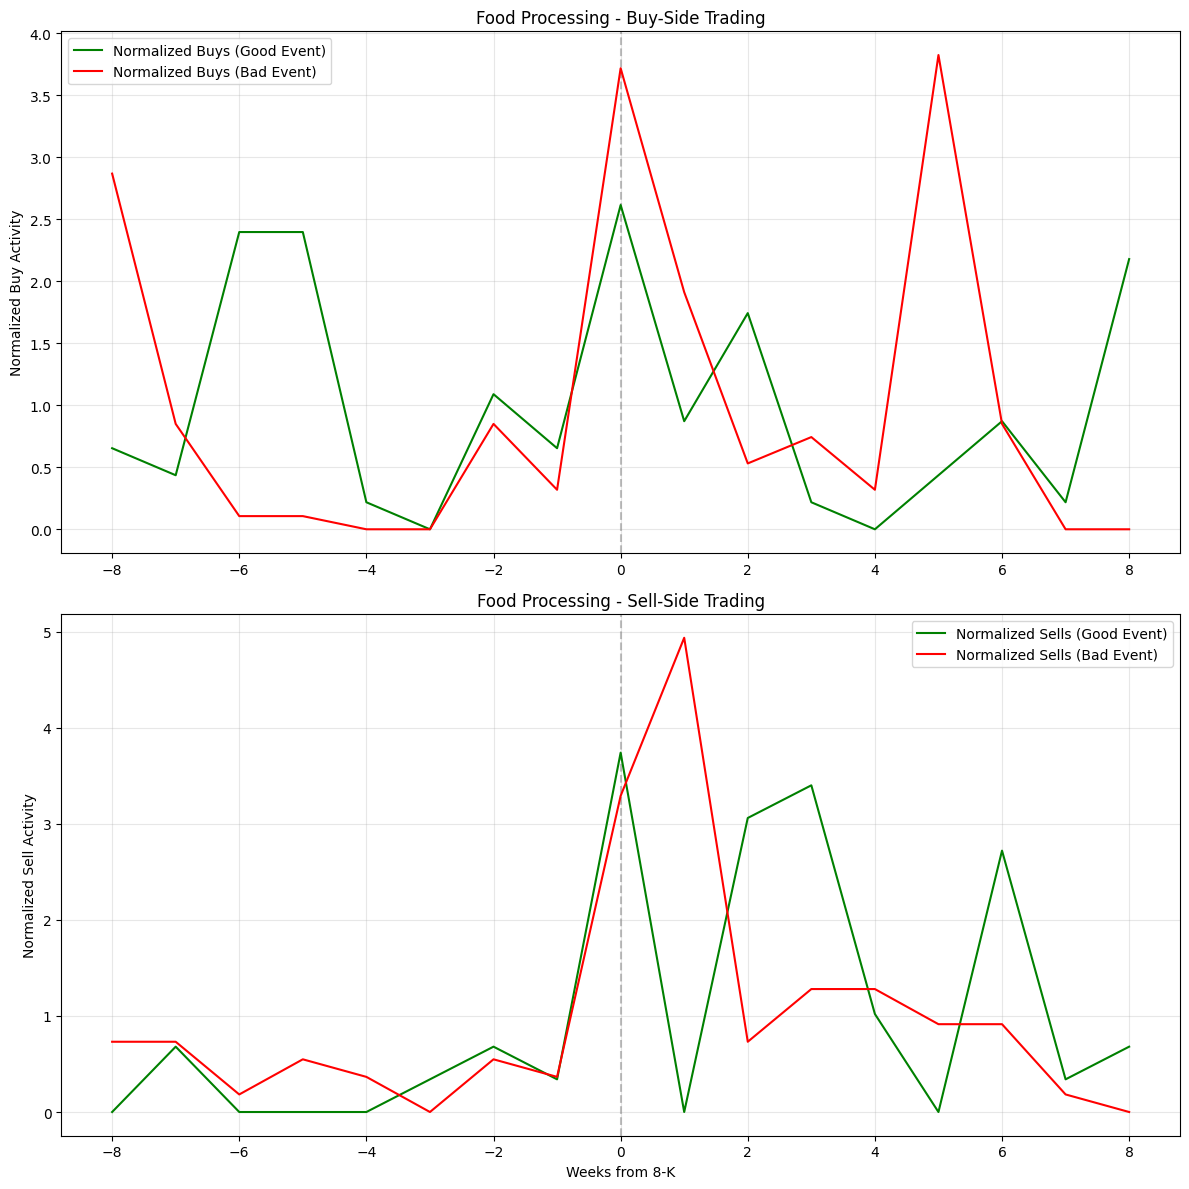

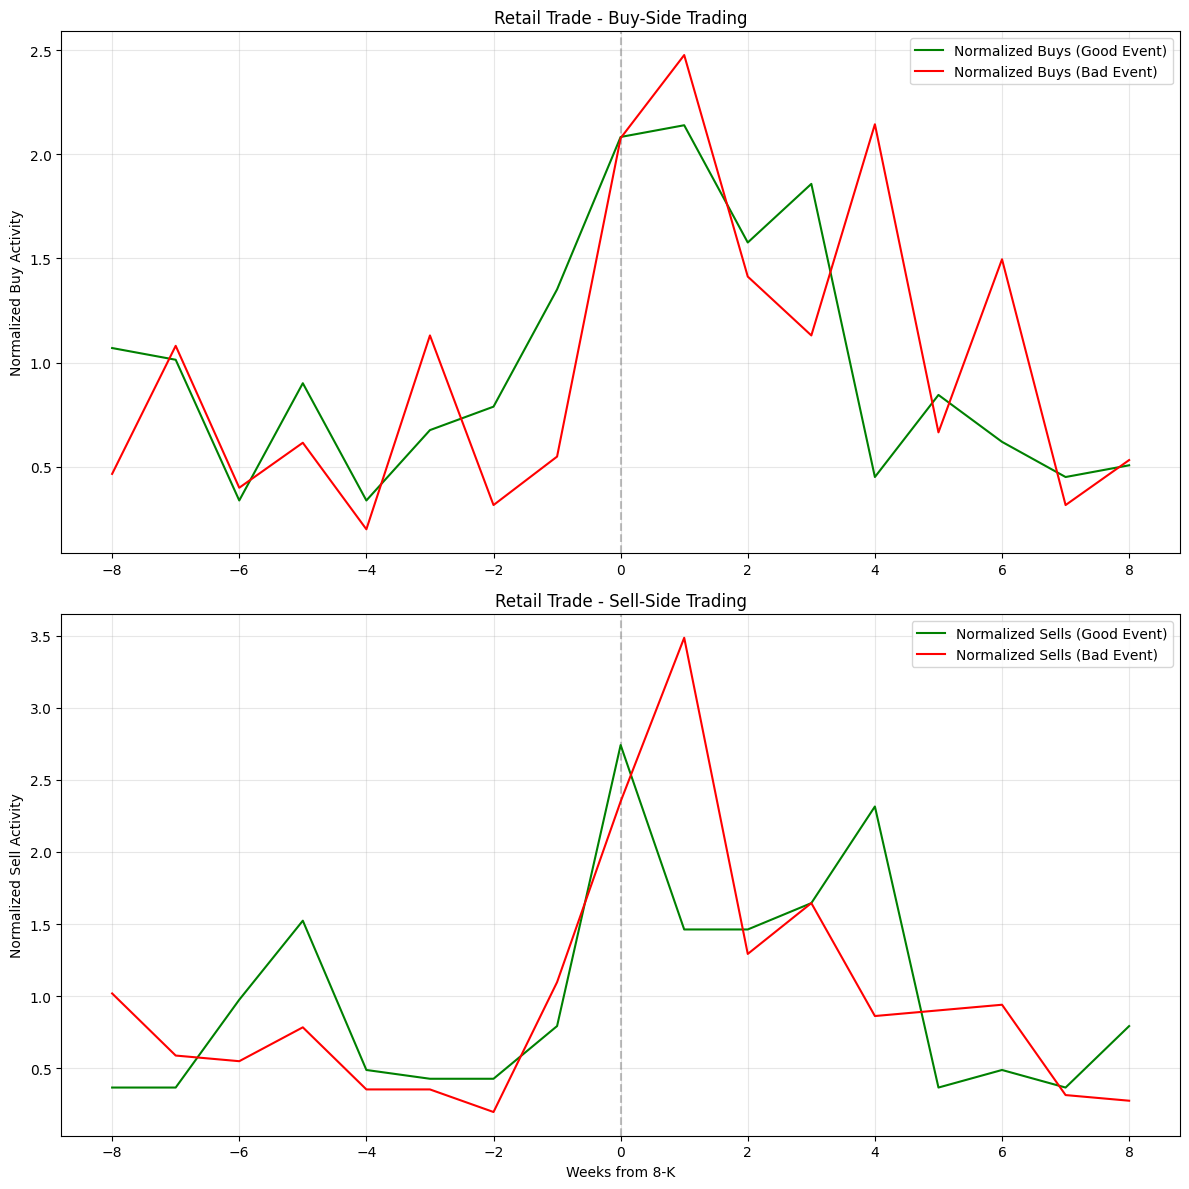

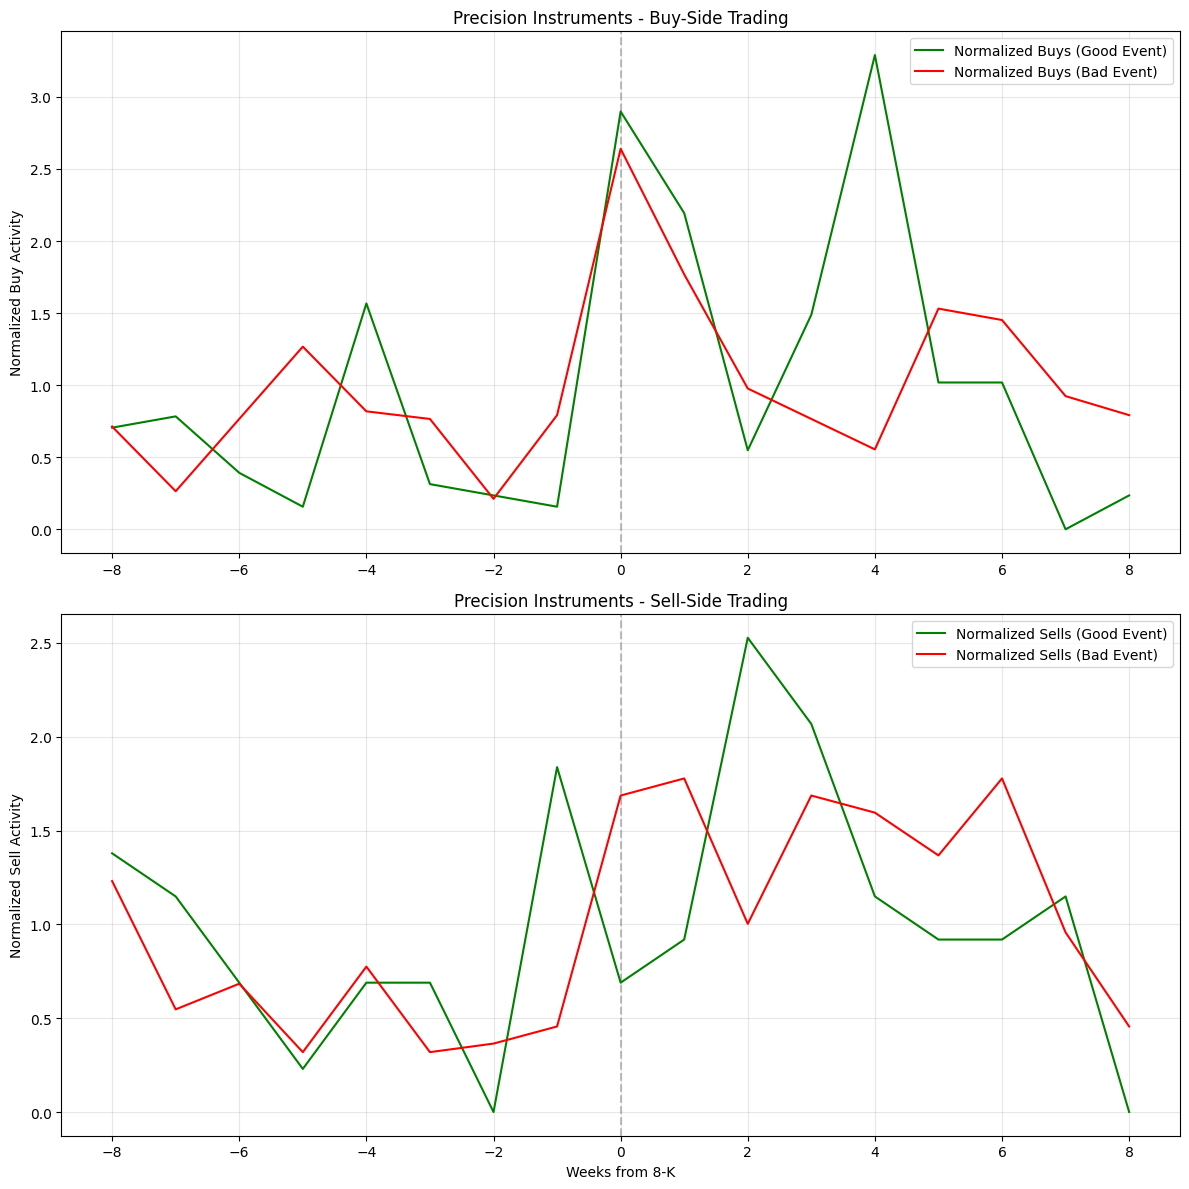

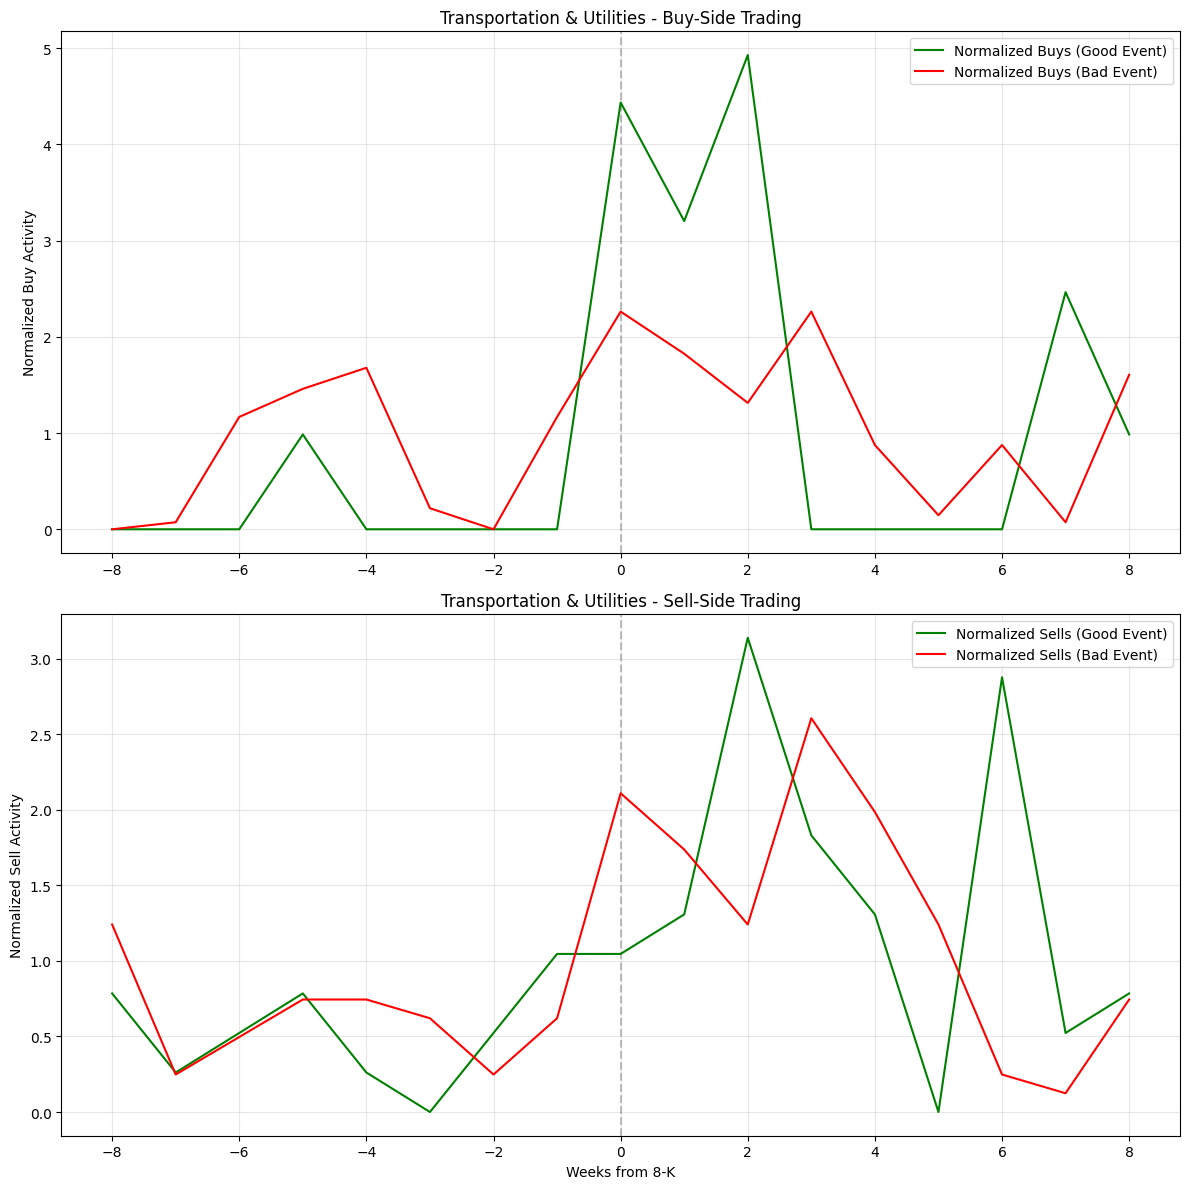

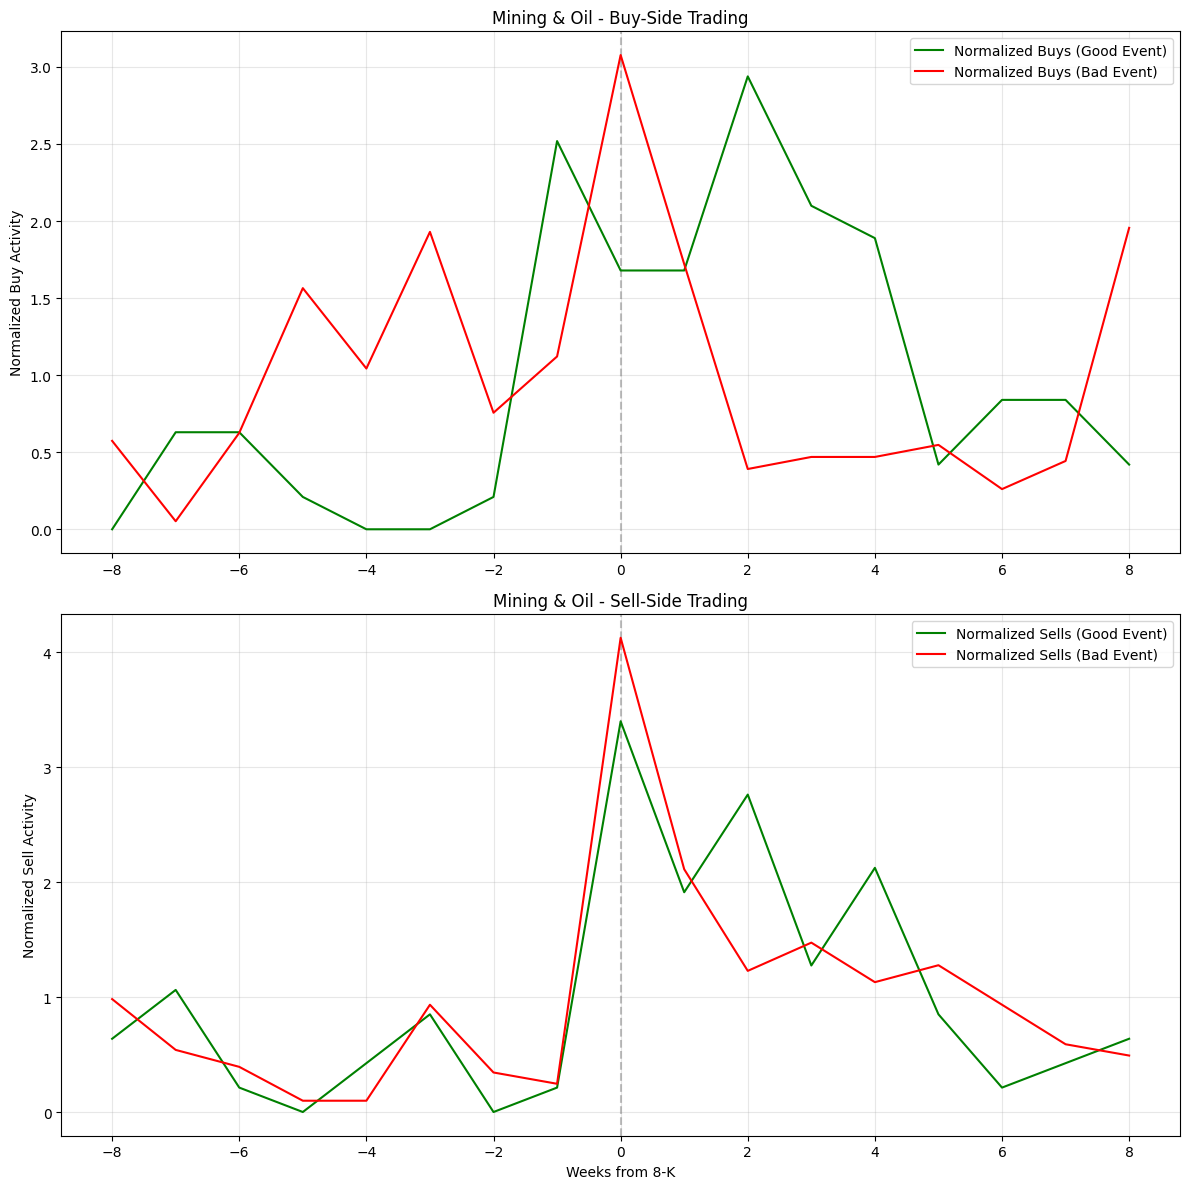

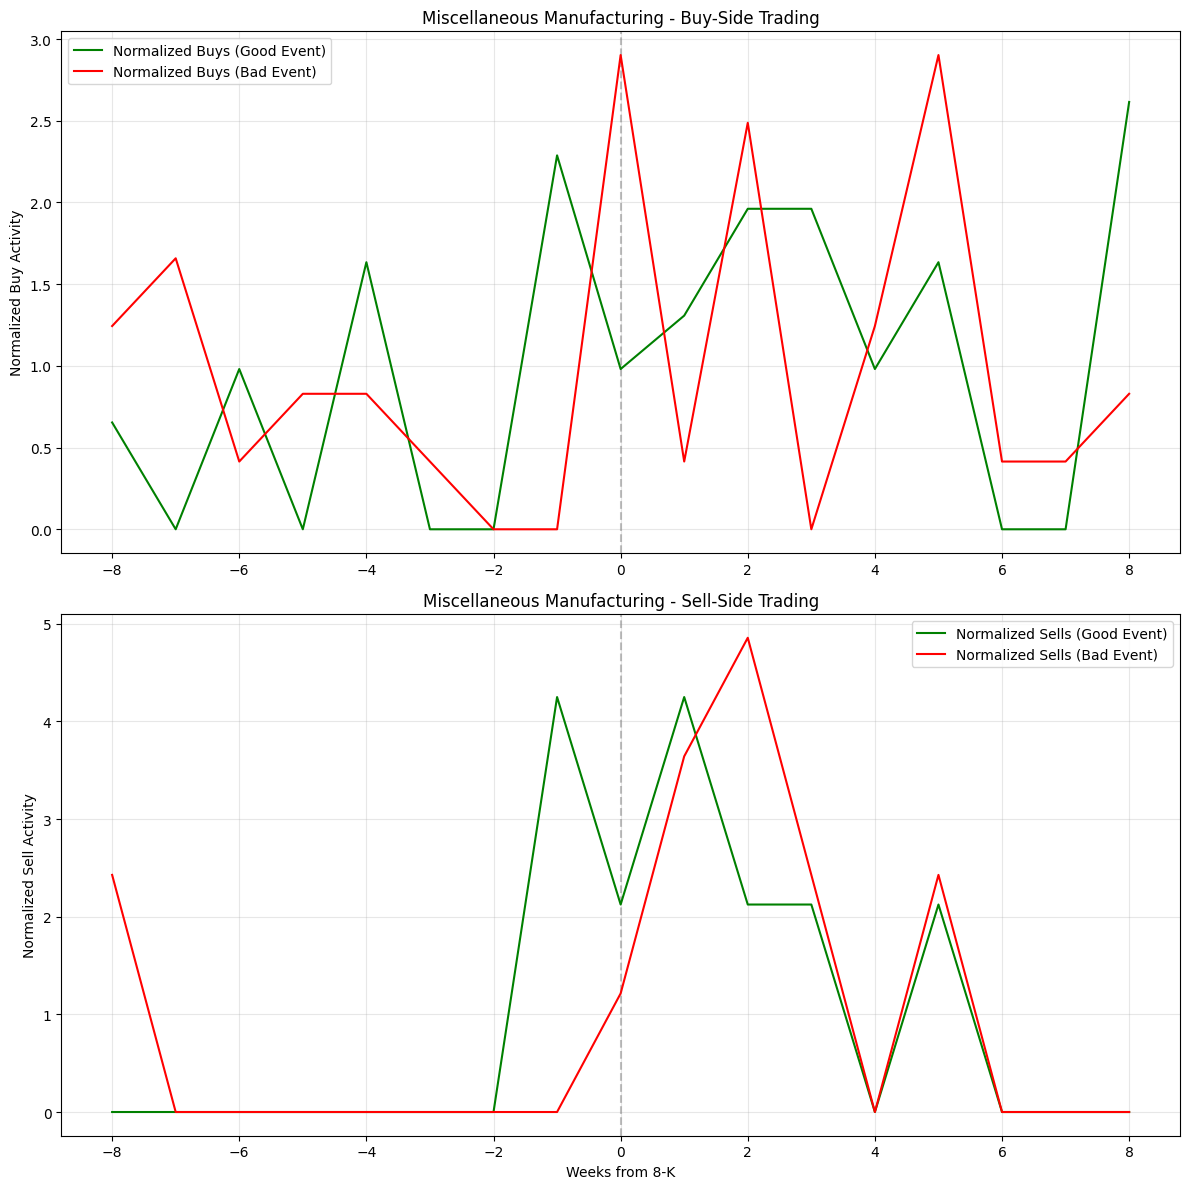

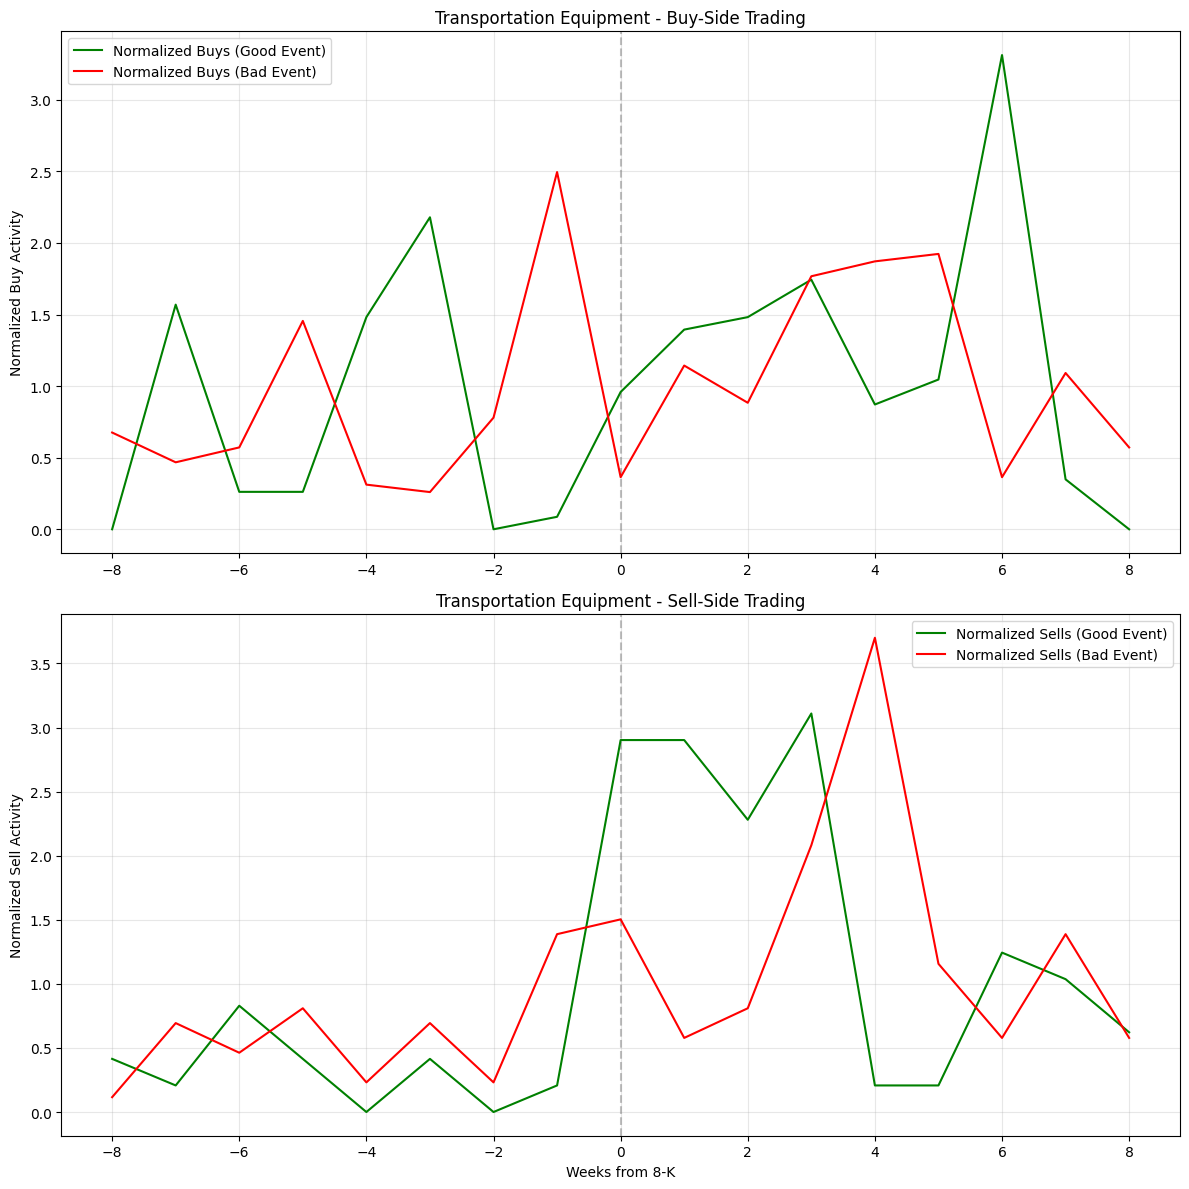

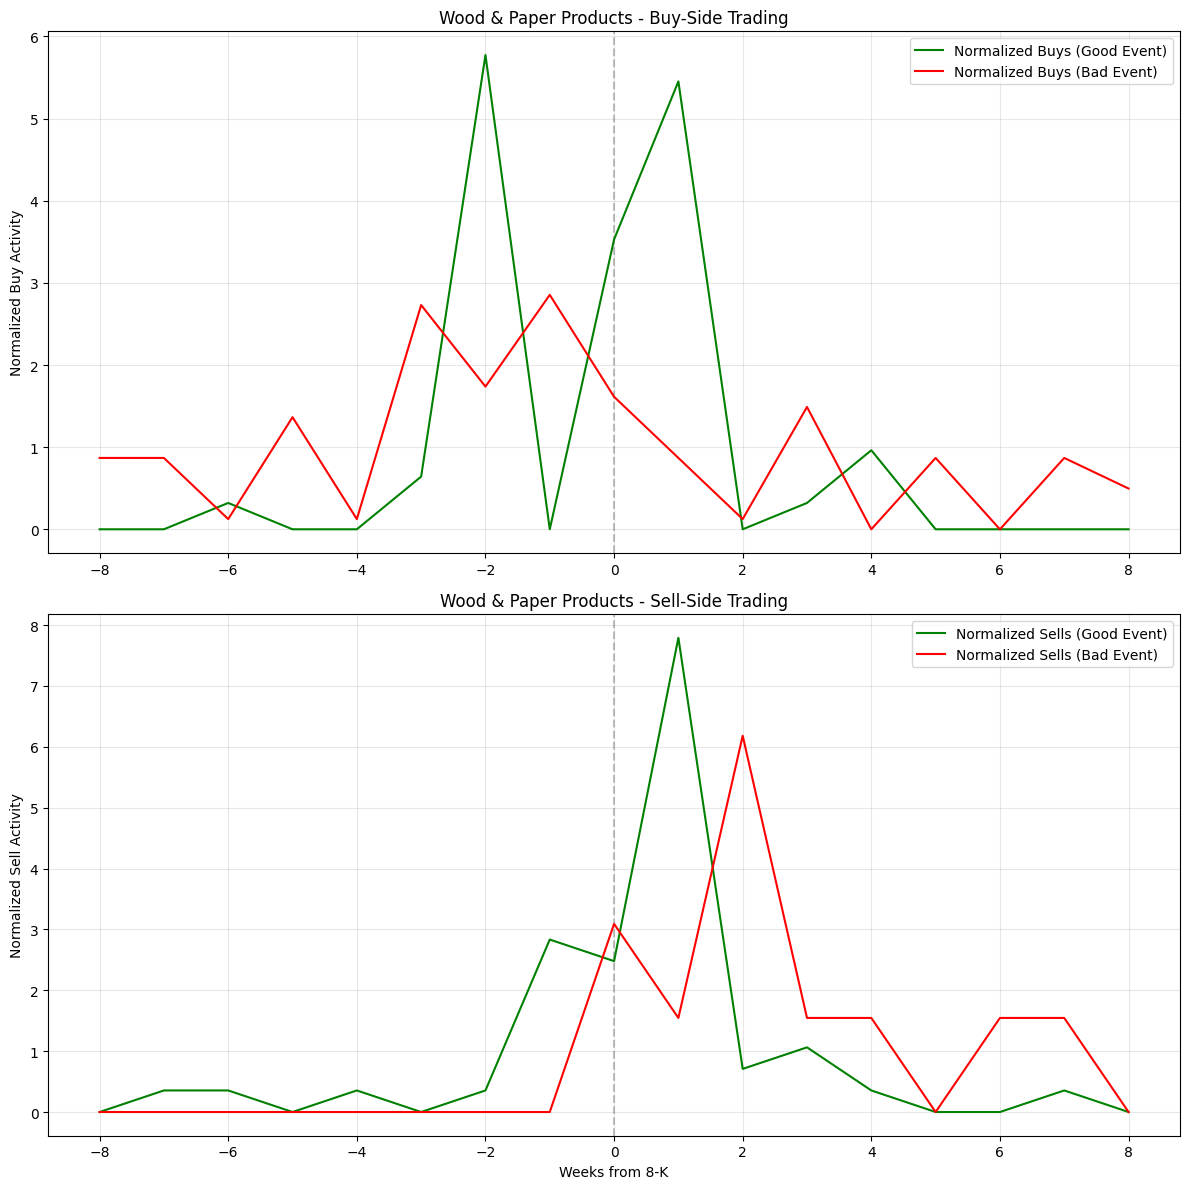

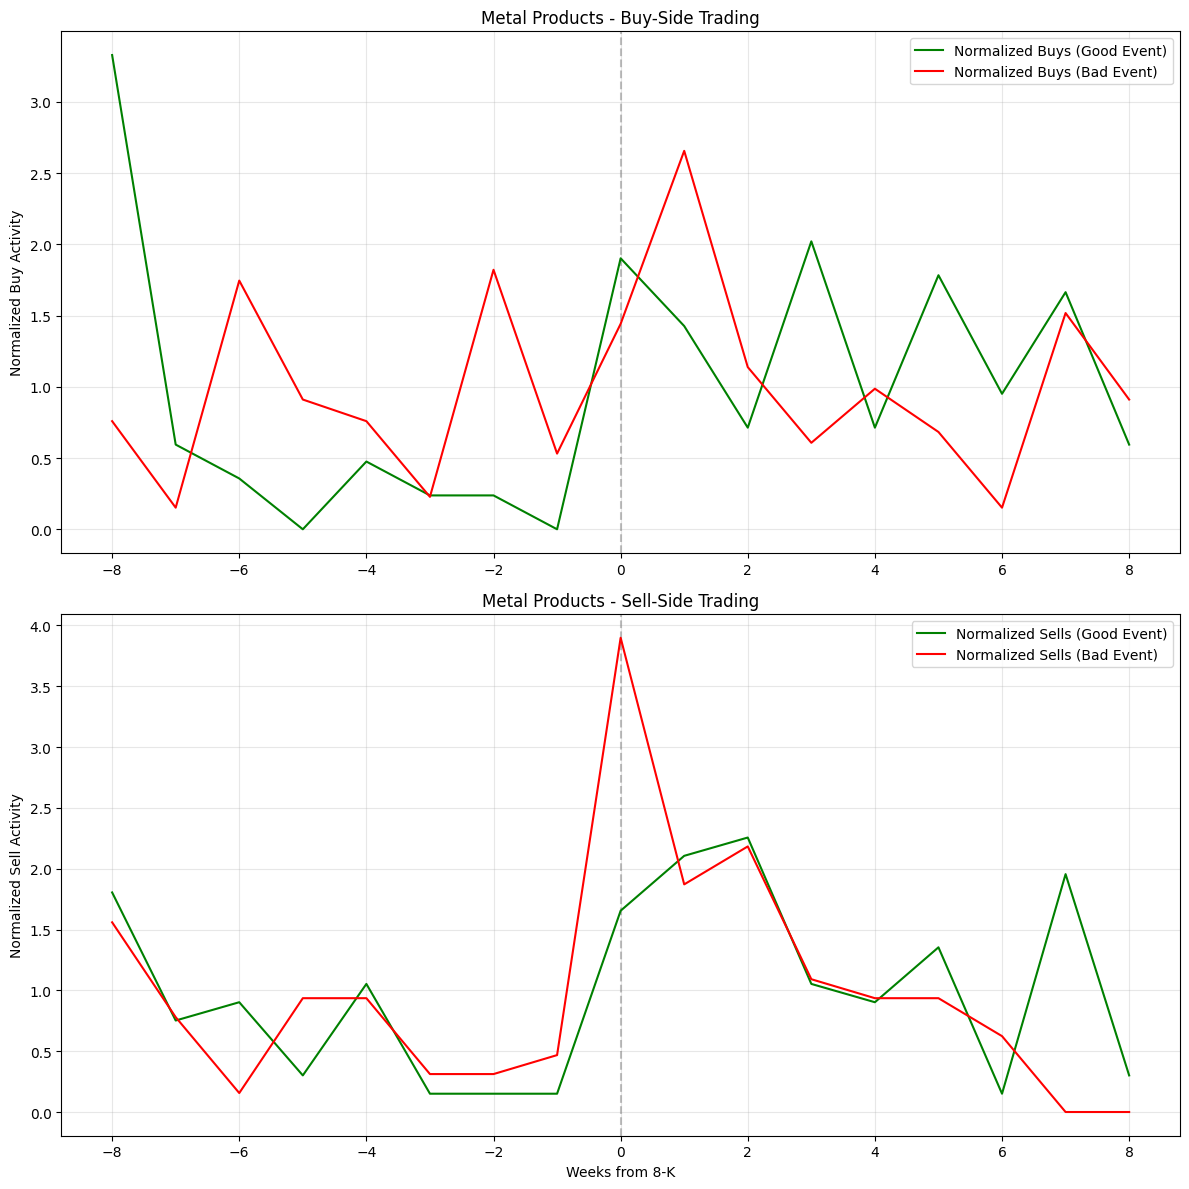

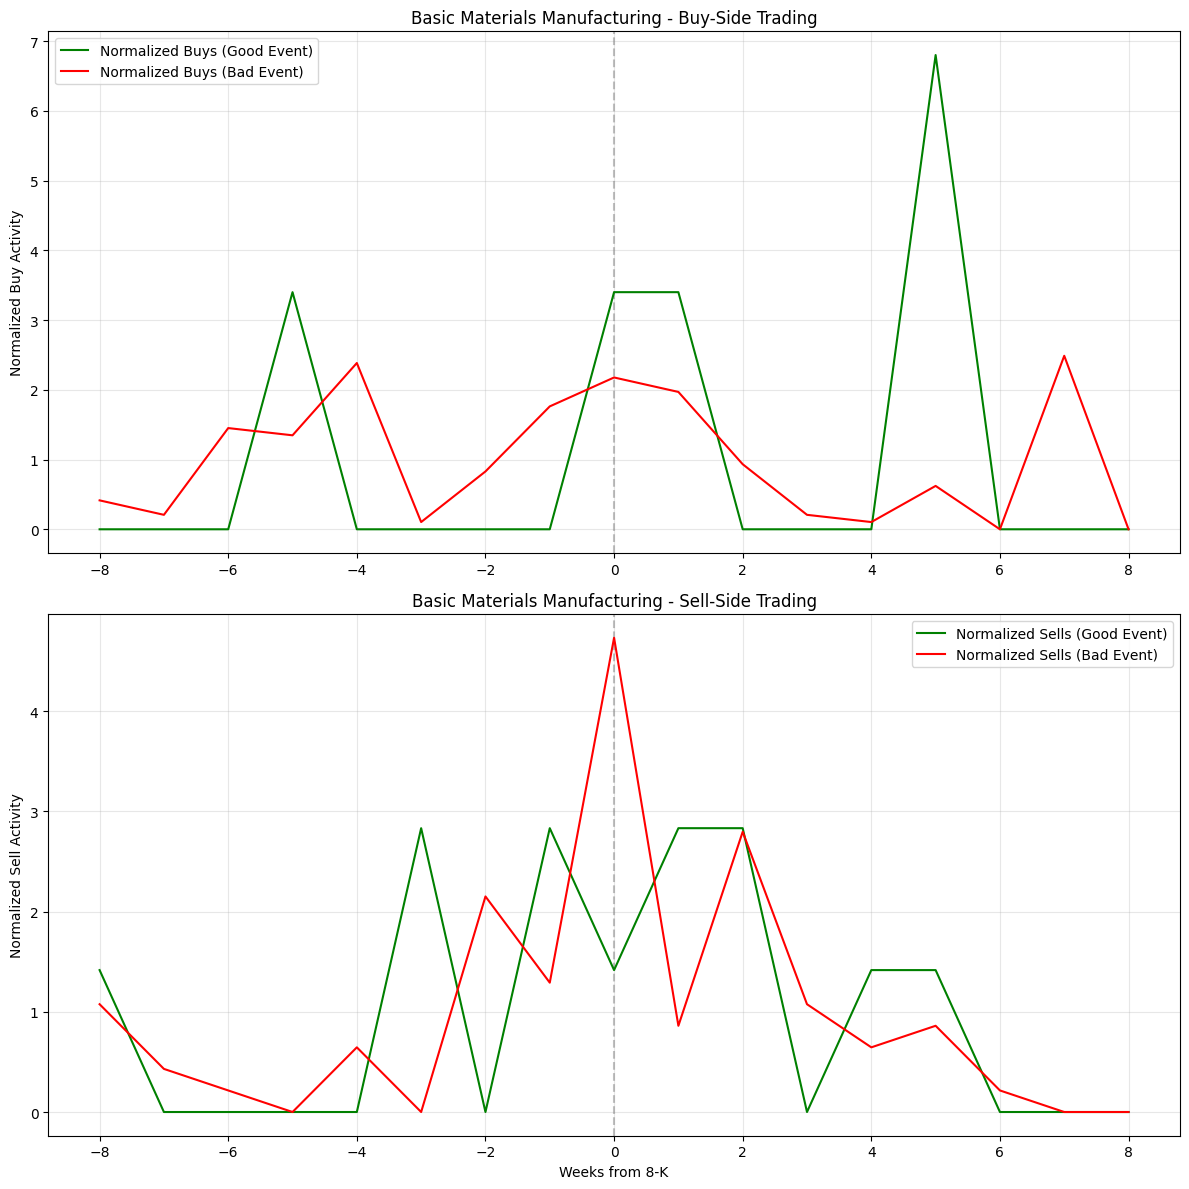

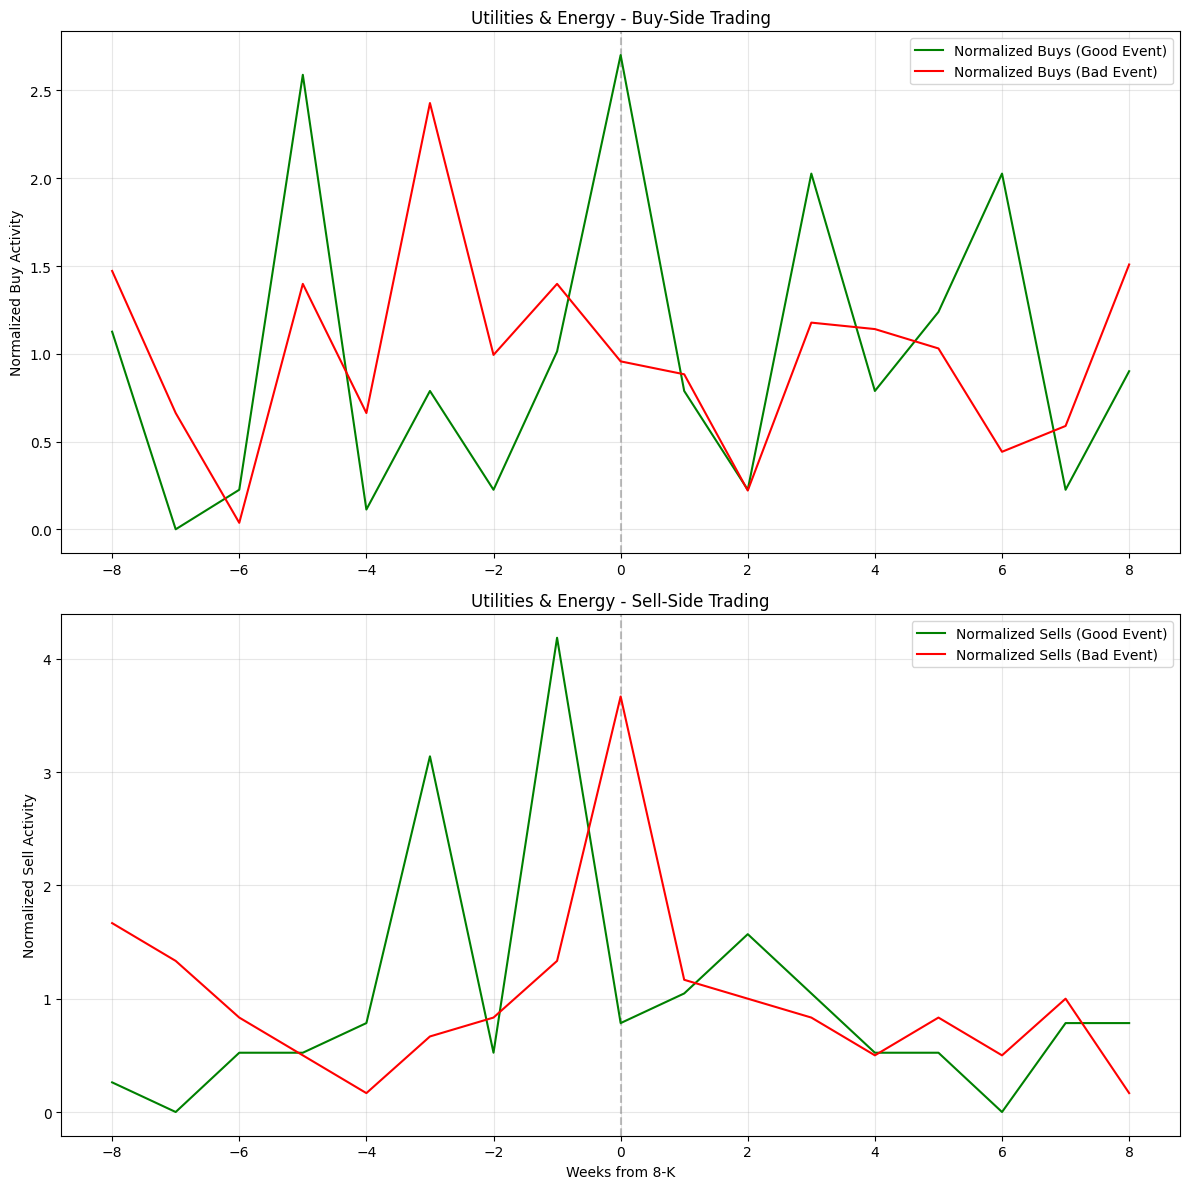

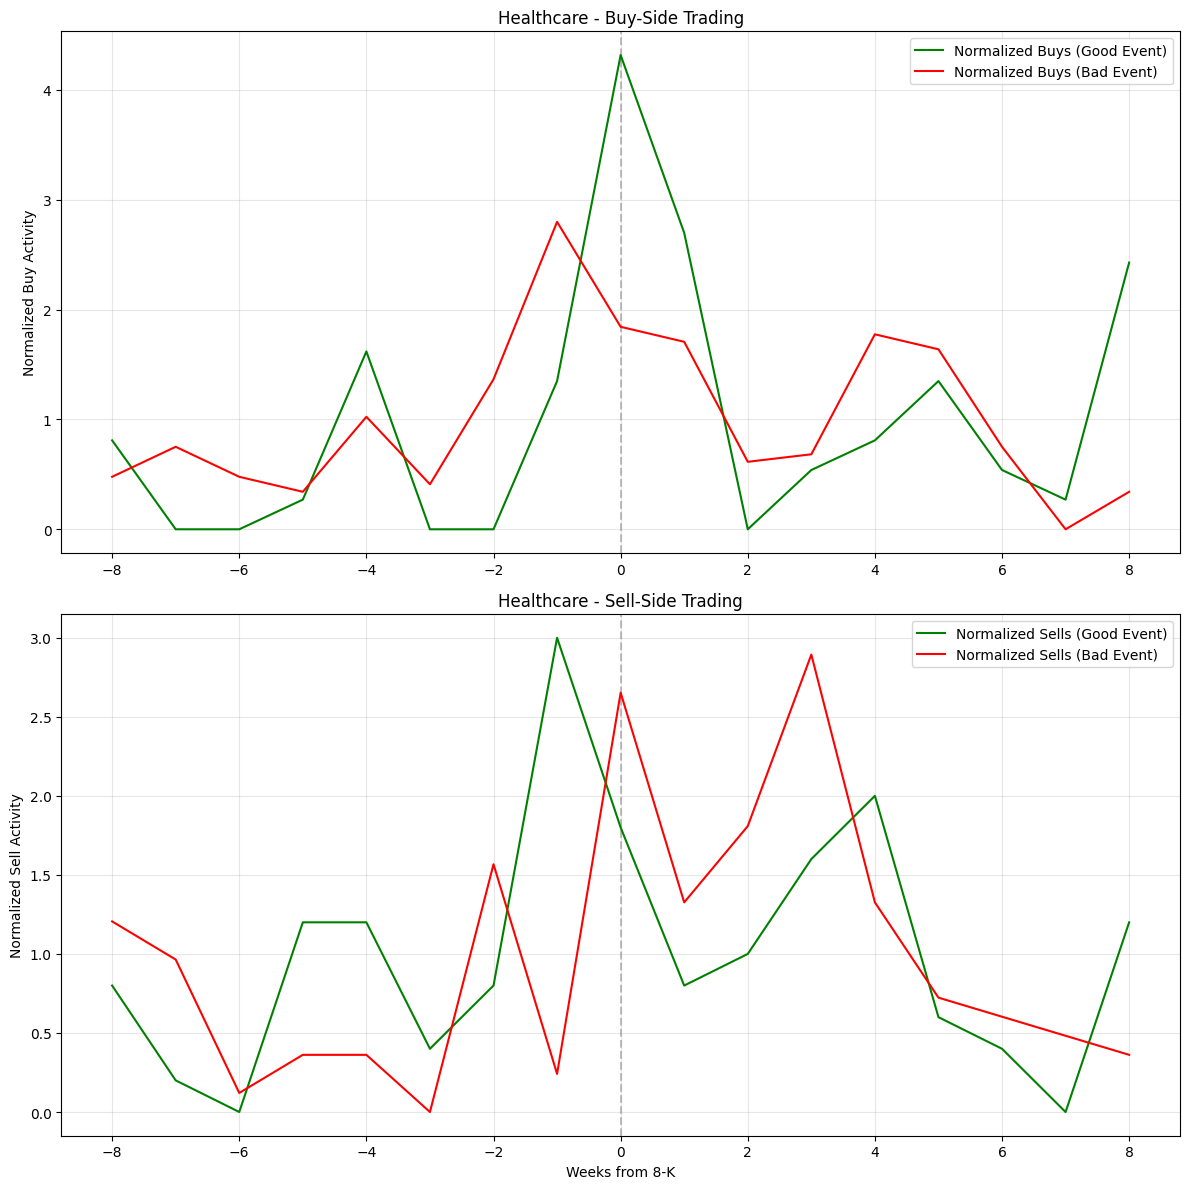

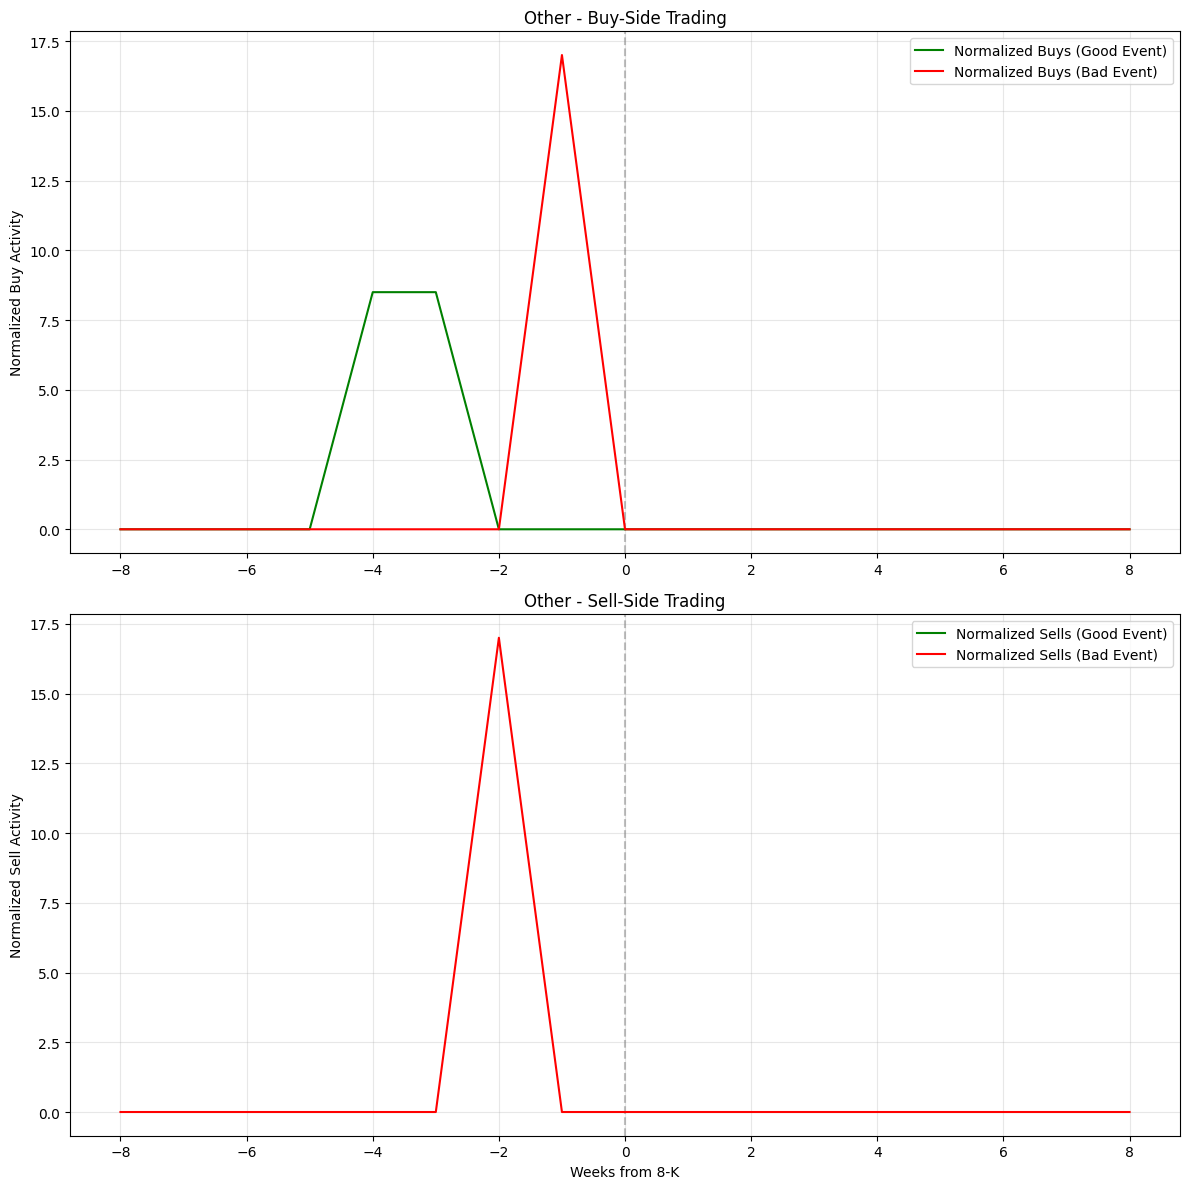

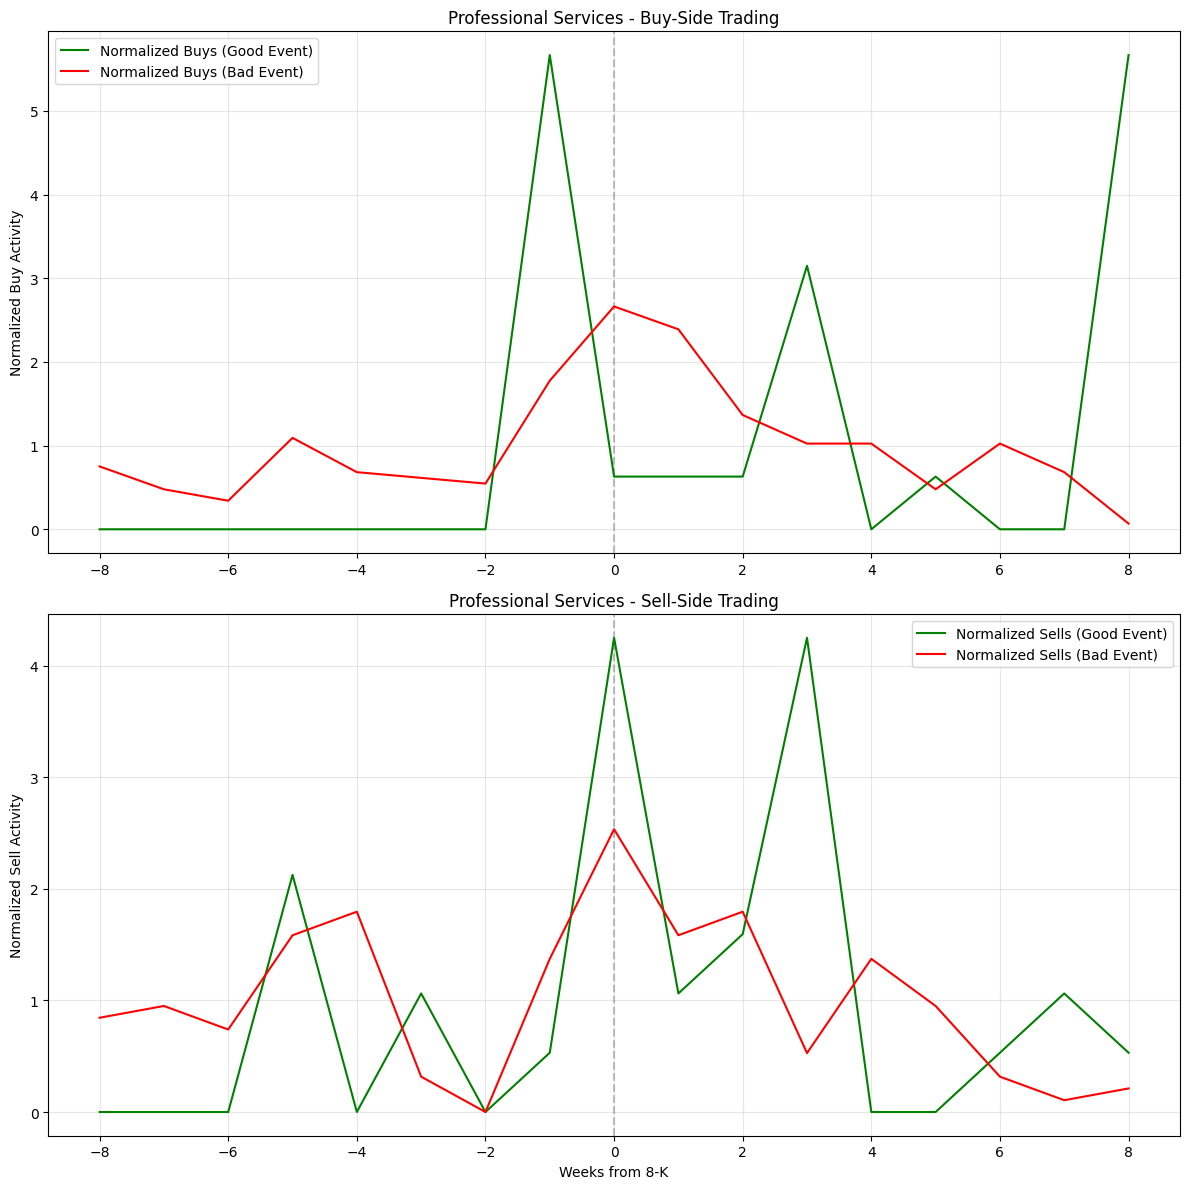

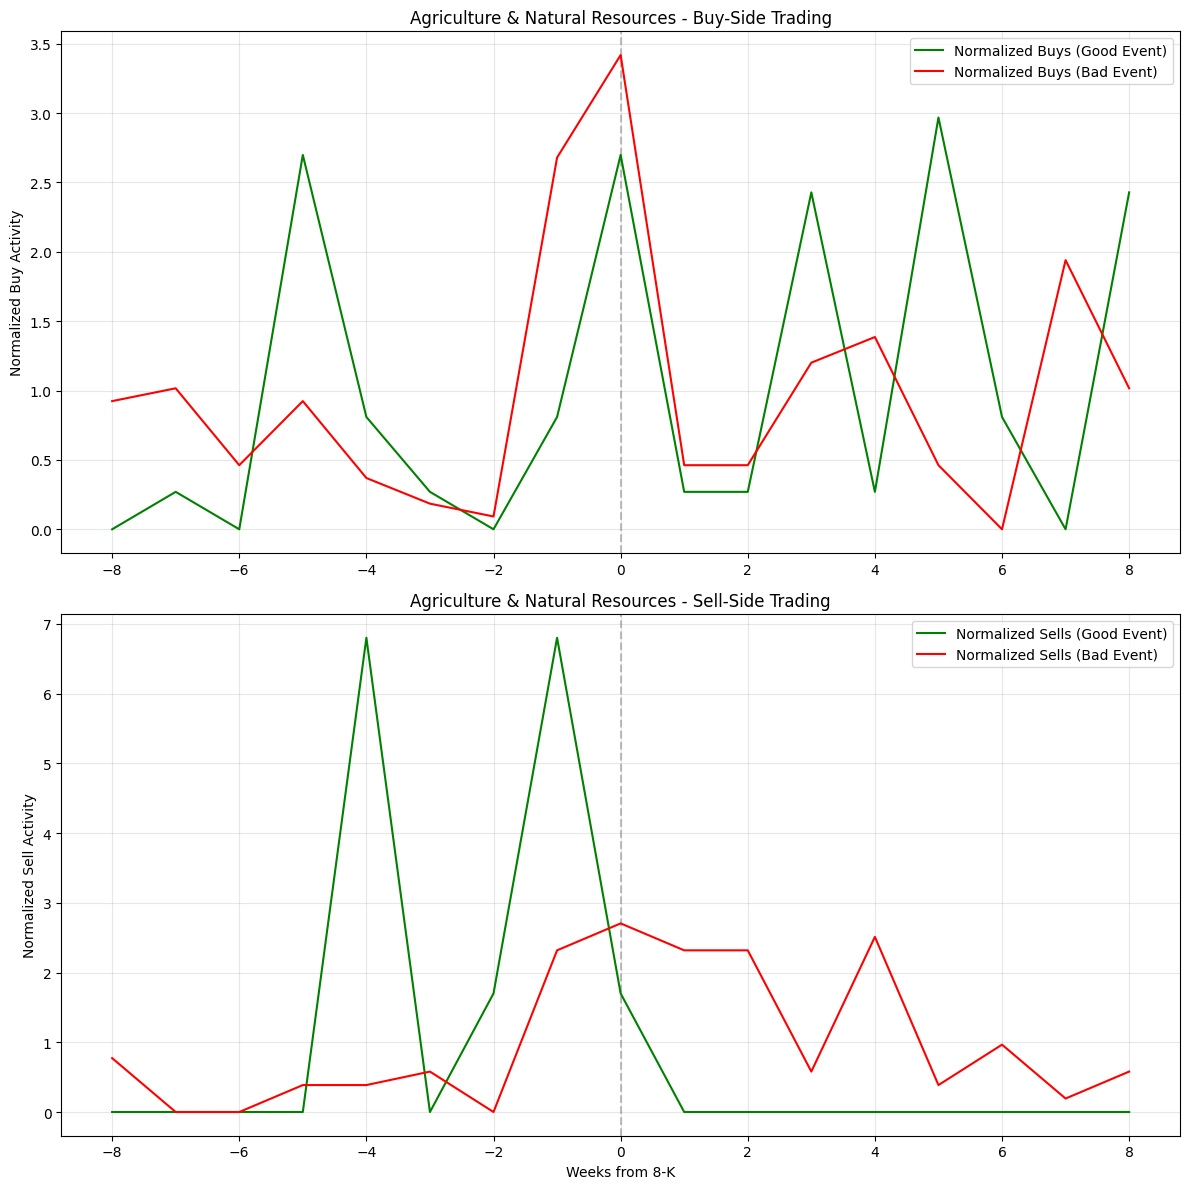

In [ ]:
import os
def plot_trading_by_sic(results_df):
   # Create positive/negative sentiment indicator
   results_df['pos_sentiment'] = results_df['sentiment'] > 0
   
   # Get unique SIC groups
   sic_groups = results_df['sic_group'].astype(str).unique()
   
   # Create output directory if it doesn't exist
   os.makedirs('plots/sic_groups', exist_ok=True)
   
   # Plot each SIC group separately
   for sic in sic_groups:
       # Create figure for this SIC group
       fig, axes = plt.subplots(2, 1, figsize=(12, 12))
       
       sic_data = results_df[results_df['sic_group'].astype(str) == sic]
       
       # Plot buys (top plot)
       ax_buy = axes[0]
       
       # Split and aggregate buy data
       pos_buys = sic_data[sic_data['pos_sentiment']].groupby('period')['buys'].mean().reset_index()
       neg_buys = sic_data[~sic_data['pos_sentiment']].groupby('period')['buys'].mean().reset_index()
       
       # Normalize buy series
       pos_buys['norm_buys'] = pos_buys['buys'] / pos_buys['buys'].mean()
       neg_buys['norm_buys'] = neg_buys['buys'] / neg_buys['buys'].mean()
       
       # Plot normalized buys
       ax_buy.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
       ax_buy.plot(pos_buys['period'], pos_buys['norm_buys'], 
                  label='Normalized Buys (Good Event)', color='green', linestyle='-')
       ax_buy.plot(neg_buys['period'], neg_buys['norm_buys'], 
                  label='Normalized Buys (Bad Event)', color='red', linestyle='-')
       
       ax_buy.set_title(f'{sic} - Buy-Side Trading')
       ax_buy.set_ylabel('Normalized Buy Activity')
       ax_buy.grid(True, alpha=0.3)
       ax_buy.legend()
       
       # Plot sells (bottom plot)
       ax_sell = axes[1]
       
       # Split and aggregate sell data
       pos_sells = sic_data[sic_data['pos_sentiment']].groupby('period')['sells'].mean().reset_index()
       neg_sells = sic_data[~sic_data['pos_sentiment']].groupby('period')['sells'].mean().reset_index()
       
       # Normalize sell series
       pos_sells['norm_sells'] = pos_sells['sells'] / pos_sells['sells'].mean()
       neg_sells['norm_sells'] = neg_sells['sells'] / neg_sells['sells'].mean()
       
       # Plot normalized sells
       ax_sell.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
       ax_sell.plot(pos_sells['period'], pos_sells['norm_sells'], 
                   label='Normalized Sells (Good Event)', color='green', linestyle='-')
       ax_sell.plot(neg_sells['period'], neg_sells['norm_sells'], 
                   label='Normalized Sells (Bad Event)', color='red', linestyle='-')
       
       ax_sell.set_title(f'{sic} - Sell-Side Trading')
       ax_sell.set_xlabel('Weeks from 8-K')
       ax_sell.set_ylabel('Normalized Sell Activity')
       ax_sell.grid(True, alpha=0.3)
       ax_sell.legend()
       
       plt.tight_layout()
       
       # Save the figure
       filename = f'plots/sic_groups/sic_{sic}.png'
       plt.savefig(filename, bbox_inches='tight', dpi=300)
       #plt.close()  # Close the figure to free memory

# Usage:
results = pd.read_csv('data/dataset.csv')
plot_trading_by_sic(results)

Yep! Massive difference in patterns across sectors.